# Prototype Notebook for A Comparative Analysis of Publisher-Curated vs. User-Generated Recipe Success Factors

## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import re
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.sparse import hstack
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
import os
os.getcwd()

'C:\\Users\\kurze\\_FINAL'

In [2]:
# Load data
df_recipes = pd.read_csv('Data/tasty_recipes.csv')
df_recipes.head()

,Recipe Title,Author,Role,Score,Total Time,Prep Time,Cook Time,Ingredients,Preparation Steps,Calories,Fat,Carbs,Fiber,Sugar,Protein,Tags,Recipe URL
0,Roasted Moroccan Carrots With Baba Ganoush,Fiona Anchal,Community Member,NaN,30 minutes,10 minutes,20 minutes,"['1 bunch dutch carrots, washed and tops trimm...",['Place carrots on a baking dish lined with ba...,72.0,4 g,8 g,2 g,2 g,2 g,"['Meal', 'Dinner', 'Weeknight', 'Kosher', 'Hal...",https://tasty.co/recipe/roasted-moroccan-carro...
1,Edamame Truffle Dumplings In Miso Broth,Nimisha Wasankar,Community Member,NaN,1 hr 10 min,40 minutes,30 minutes,"['1 package frozen shelled edamame', '2 tables...",['Cook the frozen edamame according the packag...,413.0,16 g,49 g,6 g,3 g,18 g,"['Cuisine', 'Asian', 'Japanese', 'Soy', 'Glute...",https://tasty.co/recipe/edamame-truffle-dumpli...
2,Grilled Napa Cabbage Fattoush Salad,Reza Setayesh,Community Member,NaN,40 minutes,20 minutes,20 minutes,"['1 head medium napa cabbage', '1 small red on...",['Preheat the grill and preheat the oven to 37...,430.0,29 g,32 g,2 g,6 g,9 g,"['Cuisine', 'European', 'Mediterranean', 'Kosh...",https://tasty.co/recipe/grilled-napa-cabbage-f...
3,Roasted Tomato Basil Soup,Merle O'Neal,Tasty Team,91% would make again,25 minutes,5 minutes,20 minutes,"['1 tablespoon olive oil', '1 yellow onion, di...","['In a large pot over medium heat, combine the...",48.0,0 g,9 g,1 g,2 g,1 g,"['Meal', 'Dinner', 'Soups', 'Budget', 'High-Fi...",https://tasty.co/recipe/roasted-tomato-basil-soup
4,Tuna Salad With Roasted Veggies,Mercedes Sandoval,Tasty Team,96% would make again,35 minutes,15 minutes,20 minutes,"['1 cup green beans (360 g), trimmed', '2 cups...","['Preheat the oven to 375˚F (190˚C).', 'On a b...",576.0,19 g,51 g,7 g,11 g,49 g,"['Meal', 'Lunch', 'Salads', 'Dairy', 'Fish', '...",https://tasty.co/recipe/tuna-salad-with-roaste...


The dataset contains information about various recipes, including attributes such as recipe score, keywords, cooking times, and nutritional values.

## 2. Dataset exploration

### 2.1 Basic inspection of the dataset

In [3]:
print("Basic Information:")
print(df_recipes.info())

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6604 entries, 0 to 6603
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Recipe Title       6604 non-null   object 
 1   Author             5945 non-null   object 
 2   Role               5500 non-null   object 
 3   Score              5144 non-null   object 
 4   Total Time         5397 non-null   object 
 5   Prep Time          5408 non-null   object 
 6   Cook Time          5408 non-null   object 
 7   Ingredients        6604 non-null   object 
 8   Preparation Steps  6604 non-null   object 
 9   Calories           5982 non-null   float64
 10  Fat                5982 non-null   object 
 11  Carbs              5982 non-null   object 
 12  Fiber              5982 non-null   object 
 13  Sugar              5982 non-null   object 
 14  Protein            5982 non-null   object 
 15  Tags               6604 non-null   object 
 16  Recip

Overall, the dataset is in good shape and offers strong potential for analysis after addressing minor issues like missing values and data type conversions. Given the missing values in columns, applying imputation strategies will be necessary, especially before any modeling efforts. 

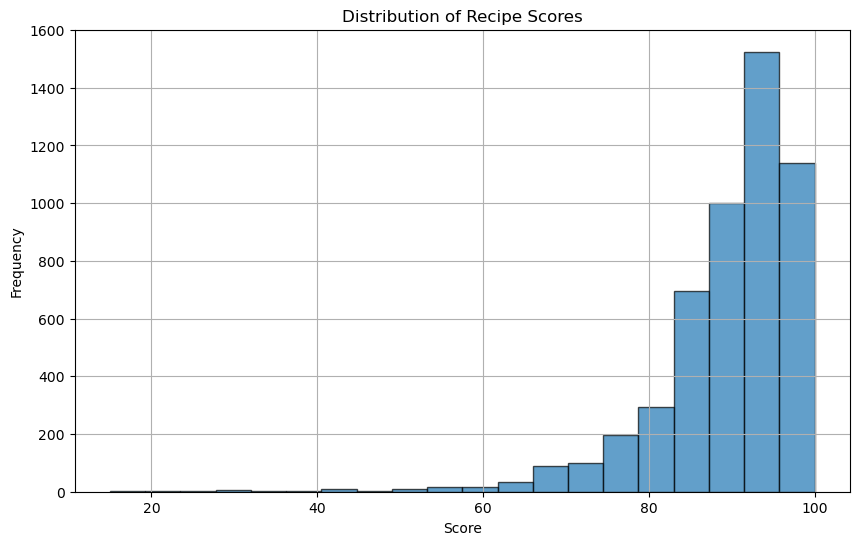

In [4]:
# Clean the Score column to extract only the numerical values
df_recipes['Score'] = df_recipes['Score'].str.extract(r'(\d+)%')[0].astype(float)

# Plot the distribution of the scores
plt.figure(figsize=(10, 6))
plt.hist(df_recipes['Score'].dropna(), bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of Recipe Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

The ratings of recipes tend to be rather on the positive side for throughout the dataset. 

In [5]:
# Transform the Role column
role_mapping = {
    'Tasty Team': 0,
    'Community Member': 1,
    None: 2
}
df_recipes['Role'] = df_recipes['Role'].map(lambda x: role_mapping.get(x, 2))

# Get the count of each role, including NaN values separately
role_counts = df_recipes['Role'].value_counts(dropna=False)
# Print the exact counts
print("Role Counts: ")
print(role_counts)

# Filter out NaN roles
filtered_df = df_recipes[df_recipes['Role'] != 2]

# Get the count of each role, excluding NaN values
role_counts_filtered = filtered_df['Role'].value_counts()

Role Counts: 
Role
0    4764
2    1104
1     736
Name: count, dtype: int64


To address the 1,747 recipes with an unassigned role (either "Community" or "Publisher"), it's essential to investigate these entries by examining the associated author of each recipe. This inspection can help identify patterns or potential correlations between the author and the missing role designation, possibly leading to more informed decisions on how to assign these roles.

In [6]:
# Identify recipes with Role = 2
role_2_recipes = df_recipes[df_recipes['Role'] == 2]

# Print unique authors for recipes with Role = 2
unique_authors_with_role_2 = role_2_recipes['Author'].dropna().unique()
print("Unique Authors with Role = 2:")
print(unique_authors_with_role_2)

Unique Authors with Role = 2:
['Kroger' 'Visit Florida' 'Walmart' 'Prego' "Hellmann's" 'KraftHeinz'
 'Lipton' "Bush's Beans" 'VisitSingapore' 'Easter Sunday'
 'Starbucks Frappuccino' 'Newell Ball' 'McCormick' 'Guinness' 'Planet Oat'
 'Intuit TurboTax Live' 'LALA' "Campbell's" "Frank's RedHot" 'Pace'
 'Cabot Creamery Co-operative' 'Bumble Bee Tuna' 'Ore-Ida'
 'Amazon Prime Fresh' 'Pepsi' 'The Little Potato Company' 'Geico'
 'Tanqueray' 'SpongeTowels' 'Pillsbury' 'Heluva Good' 'Crown Royal'
 'Castle Wood Reserve' 'Napoleon' 'Captain Morgan' 'Bulleit'
 'Charter Reserve' "Welch's" 'McCain Foods' 'DoorDash' "Justin's"
 'Snyder’s of Hanover®' 'Albertsons' 'Cholula' 'Stella Rosa® Wines'
 'Grill Mates' 'Sabra' 'Deep Indian Kitchen' 'Sun-Bird' 'Juicy Juice'
 'Next Level Chef on Fox' 'Birds Eye' "French's" 'Kerrygold' 'Modelo'
 'Impossible™ Foods' 'Chase' 'Pure Leaf' 'Mezzetta' 'Biden For President'
 "BJ's Wholesale" 'Palmolive' 'Signature Select' 'Incredible Egg'
 'Country Crock® Plant Based an

Those recipes can be identified as published by official partners and will belong to non-community recipes. Assigning these roles correctly ensures better organization and more accurate categorization within the dataset.

In [7]:
# Update Role = 2 to Role = 0 for partner recipes with identified authors
for author in unique_authors_with_role_2:
    matching_recipes = df_recipes.loc[(df_recipes['Author'] == author) & (df_recipes['Role'] == 2)]
    df_recipes.loc[(df_recipes['Author'] == author) & (df_recipes['Role'] == 2), 'Role'] = 0
    
# Get the count of each role after the update
role_counts_after = df_recipes['Role'].value_counts()

# Print the exact counts after the update
print("Role Counts after updating specific Role = 2 to Role = 0:")
print(role_counts_after)

Role Counts after updating specific Role = 2 to Role = 0:
Role
0    5209
1     736
2     659
Name: count, dtype: int64


Before the update, there were 1104 recipes with an unassigned role. After reclassifying recipes as non-community (Role = 0), 659 recipes still remain with unassigned roles (Role = 2). While these entries may not be ideal for training models due to their incomplete categorization, they can still be valuable for imputing missing values within the dataset.

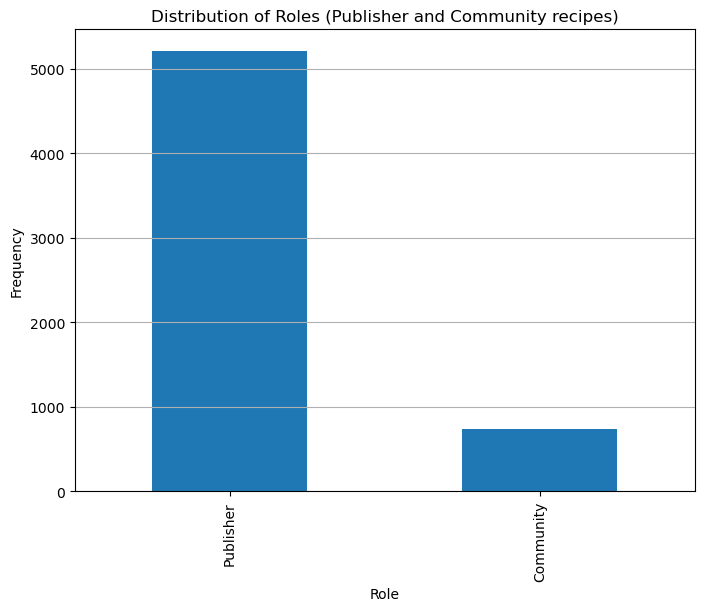

In [8]:
# Filter out NaN roles for plotting
filtered_df_after = df_recipes[df_recipes['Role'] != 2]

# Get the count of each role, excluding NaN values
role_counts_filtered_after = filtered_df_after['Role'].value_counts()

# Plot the distribution of the Role column excluding NaN
plt.figure(figsize=(8, 6))
role_counts_filtered_after.plot(kind='bar')
plt.title('Distribution of Roles (Publisher and Community recipes)')
plt.xlabel('Role')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1], labels=['Publisher', 'Community'])
plt.grid(axis='y')
plt.show()

### Learnings from basic data exploration

1. **Imbalance in Data**:
   - The number of publisher recipes (8071) is significantly higher than the number of community recipes (1128). This indicates an imbalance in the dataset.

2. **Publisher Recipes**:
   - These are likely to be more standardized, possibly following specific guidelines and quality checks.
   - They may have more consistent and complete data, making them potentially more reliable for training models.

3. **Community Recipes**:
   - These recipes might exhibit more variability in style, ingredients, and instructions, reflecting a wider range of cooking practices and preferences.
   - They could provide valuable diversity to the dataset, capturing a broader spectrum of culinary creativity.

4. **Separate Analysis**:
   - Given the disparity, it might be useful to analyze publisher and community recipes separately to understand unique patterns and features within each group.

6. **Feature Importance**:
   - Analyzing feature importance separately for each group might uncover different driving factors for each type of recipe, aiding in more tailored recommendations and insights.

### 2.2 Data cleaning and exploration of publisher and community data

To better understand the distinctions between community and publisher recipes, the next step involves data cleaning and preprocessing. This will include addressing any inconsistencies, handling missing values, and preparing the dataset for further analysis, along with visual data exploration to uncover patterns, relationships, and potential differences between community and publisher recipes. 

In [9]:
# Function to convert time strings to minutes
def convert_to_minutes(time_str):
    if pd.isna(time_str):
        return None
    time_str = time_str.lower()
    minutes = 0
    if 'hr' in time_str:
        hours = re.search(r'(\d+)\s*hr', time_str)
        if hours:
            minutes += int(hours.group(1)) * 60
    if 'min' in time_str:
        mins = re.search(r'(\d+)\s*min', time_str)
        if mins:
            minutes += int(mins.group(1))
    elif 'minute' in time_str:
        mins = re.search(r'(\d+)\s*minute', time_str)
        if mins:
            minutes += int(mins.group(1))
    return minutes

# Apply the function to transform cooking times to floats
df_recipes['Total Time'] = df_recipes['Total Time'].apply(convert_to_minutes)
df_recipes['Prep Time'] = df_recipes['Prep Time'].apply(convert_to_minutes)
df_recipes['Cook Time'] = df_recipes['Cook Time'].apply(convert_to_minutes)

In [10]:
# Function to remove 'g' from nutritional values and convert to floats
def remove_g(value):
    if pd.isna(value):
        return None
    return float(value.replace('g', '').strip())

# Apply the function to nutritional data columns
df_recipes['Fat'] = df_recipes['Fat'].apply(lambda x: remove_g(str(x)))
df_recipes['Carbs'] = df_recipes['Carbs'].apply(lambda x: remove_g(str(x)))
df_recipes['Fiber'] = df_recipes['Fiber'].apply(lambda x: remove_g(str(x)))
df_recipes['Sugar'] = df_recipes['Sugar'].apply(lambda x: remove_g(str(x)))
df_recipes['Protein'] = df_recipes['Protein'].apply(lambda x: remove_g(str(x)))

In [11]:
# Split the data into Publisher and Community Member
publisher_recipes = df_recipes[df_recipes['Role'] == 0]
community_recipes = df_recipes[df_recipes['Role'] == 1]

# Basic statistics for each group
print("Basic Statistics for Publisher Recipes:")
print(publisher_recipes.describe())

print("\nBasic Statistics for Community Member Recipes:")
print(community_recipes.describe())

Basic Statistics for Publisher Recipes:
         Role        Score   Total Time    Prep Time    Cook Time  \
count  5209.0  4420.000000  4145.000000  4156.000000  4156.000000   
mean      0.0    89.192081    98.363329    32.418191    42.500722   
std       0.0     8.852567   137.547367    59.599133    70.102752   
min       0.0    15.000000     1.000000     1.000000     1.000000   
25%       0.0    86.000000    35.000000    15.000000    15.000000   
50%       0.0    92.000000    55.000000    20.000000    25.000000   
75%       0.0    95.000000   100.000000    30.000000    45.000000   
max       0.0   100.000000  1410.000000  1060.000000  1425.000000   

          Calories          Fat        Carbs        Fiber        Sugar  \
count  4695.000000  4695.000000  4695.000000  4695.000000  4695.000000   
mean    453.541001    21.358466    46.237274     4.010437    17.656230   
std     299.812477    18.748440    36.861334     5.393120    19.301595   
min       0.000000     0.000000     0.0000

- **Publisher Recipes**:
  - These recipes have a higher average score (89.2) and a broad range of total cooking times, averaging 98.36 minutes. The nutritional values show a moderate calorie content (453.54 kcal on average) with a balanced mix of fats, carbs, and proteins.
  - The large standard deviations suggest significant diversity in recipe complexity and nutritional profiles.

- **Community Member Recipes**:
  - Community recipes feature slightly lower average scores (87.6) and shorter total times (71.39 minutes). The nutritional profile is similar but slightly lighter, with a lower average calorie count (424.09 kcal).
  - The more uniform distribution suggests less variation, indicating generally simpler and quicker recipes.

These insights indicate that publisher recipes are more diverse and potentially more complex, whereas community recipes tend to be simpler and quicker to prepare. The slightly lower scores of community recipes may reflect their relative simplicity.

In [12]:
# Basic Information
print("Basic information for Publisher Recipes:")
print(publisher_recipes.info())

print("\nBasic information for Community Member Recipes:")
print(community_recipes.info())

Basic information for Publisher Recipes:
<class 'pandas.core.frame.DataFrame'>
Index: 5209 entries, 3 to 6603
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Recipe Title       5209 non-null   object 
 1   Author             5209 non-null   object 
 2   Role               5209 non-null   int64  
 3   Score              4420 non-null   float64
 4   Total Time         4145 non-null   float64
 5   Prep Time          4156 non-null   float64
 6   Cook Time          4156 non-null   float64
 7   Ingredients        5209 non-null   object 
 8   Preparation Steps  5209 non-null   object 
 9   Calories           4695 non-null   float64
 10  Fat                4695 non-null   float64
 11  Carbs              4695 non-null   float64
 12  Fiber              4695 non-null   float64
 13  Sugar              4695 non-null   float64
 14  Protein            4695 non-null   float64
 15  Tags               5209 non-null   o

After splitting between Publisher and Community recipes, it is evident that some fields (eg. 'Score'), particularly for community recipes, are sparse and will require imputation or special handling during analysis.

A further visual exploration of the features in the dataset will provide insights into the differences between the two recipe types. 

### Recipe scores

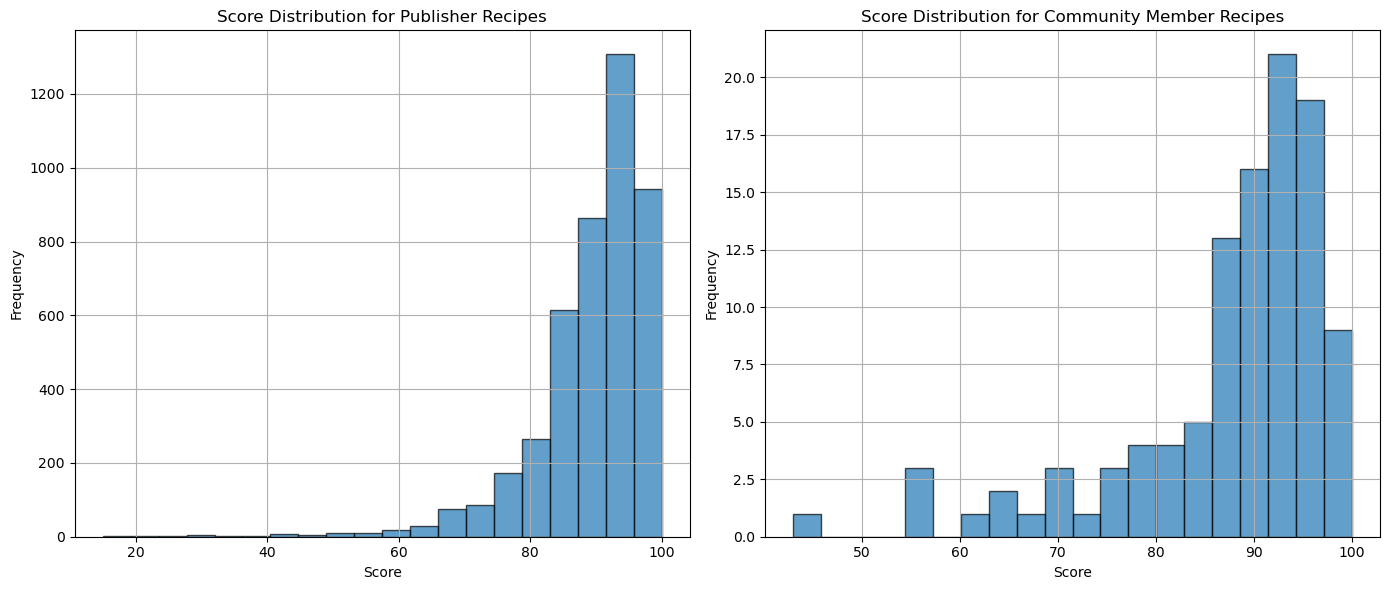

In [13]:
# Score distribution for each group
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(publisher_recipes['Score'].dropna(), bins=20, edgecolor='k', alpha=0.7)
plt.title('Score Distribution for Publisher Recipes')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(community_recipes['Score'].dropna(), bins=20, edgecolor='k', alpha=0.7)
plt.title('Score Distribution for Community Member Recipes')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()

- **Publisher Recipes:** The scores show a concentrated distribution, with most scores falling between 85 and 100. The mean score is now approximately 89, with a tighter spread, indicating that publisher recipes generally maintain a consistently high standard. The histogram supports this, showing a clear peak near the upper range of the scores.

- **Community Member Recipes:** The scores are more spread out, with a significant number of high scores close to 100. The mean score is slightly lower at about 87.6, and the distribution is broader compared to publisher recipes, suggesting more variability in quality among community contributions.

Both groups display a high frequency of recipes with scores in the upper range, reflecting overall quality, with publisher recipes being slightly more consistent in achieving higher scores.

### Cooking times

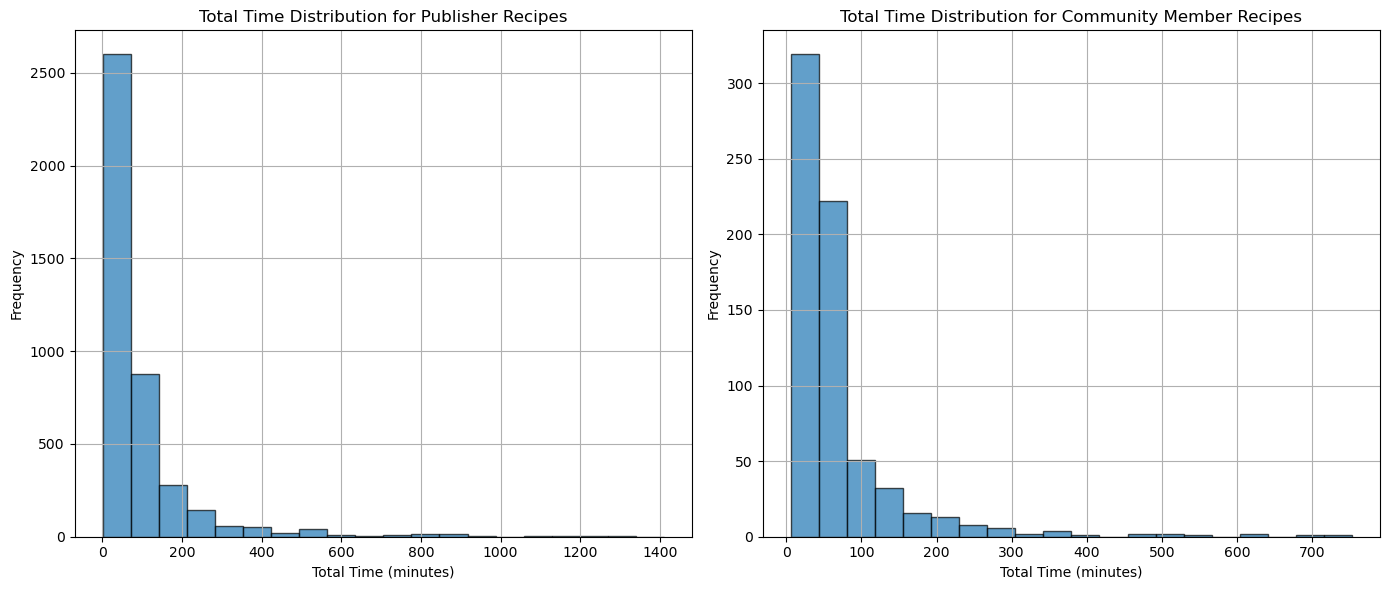

In [14]:
# Plot total time distribution for each group
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(publisher_recipes['Total Time'].dropna(), bins=20, edgecolor='k', alpha=0.7)
plt.title('Total Time Distribution for Publisher Recipes')
plt.xlabel('Total Time (minutes)')
plt.ylabel('Frequency')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(community_recipes['Total Time'].dropna(), bins=20, edgecolor='k', alpha=0.7)
plt.title('Total Time Distribution for Community Member Recipes')
plt.xlabel('Total Time (minutes)')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()

- **Publisher Recipes:** The scores remain concentrated, mostly between 85 and 100, with a mean of 89.19, indicating a consistently high standard. The total cooking time distribution still skews left, with most recipes under 200 minutes and a strong peak below 100 minutes. However, the range now extends up to 1400 minutes, reflecting a diverse range of recipes.

- **Community Member Recipes:** Scores are more varied but generally high, with a mean of 87.63. The total time distribution is similar to that of publisher recipes, though with fewer extreme outliers and a maximum time of around 700 minutes. This suggests simpler and quicker recipes compared to those from publishers.

Overall, publisher recipes show a wider range of complexity and cooking time, while community recipes tend to be more consistent and quicker to prepare.

### Nutritional values

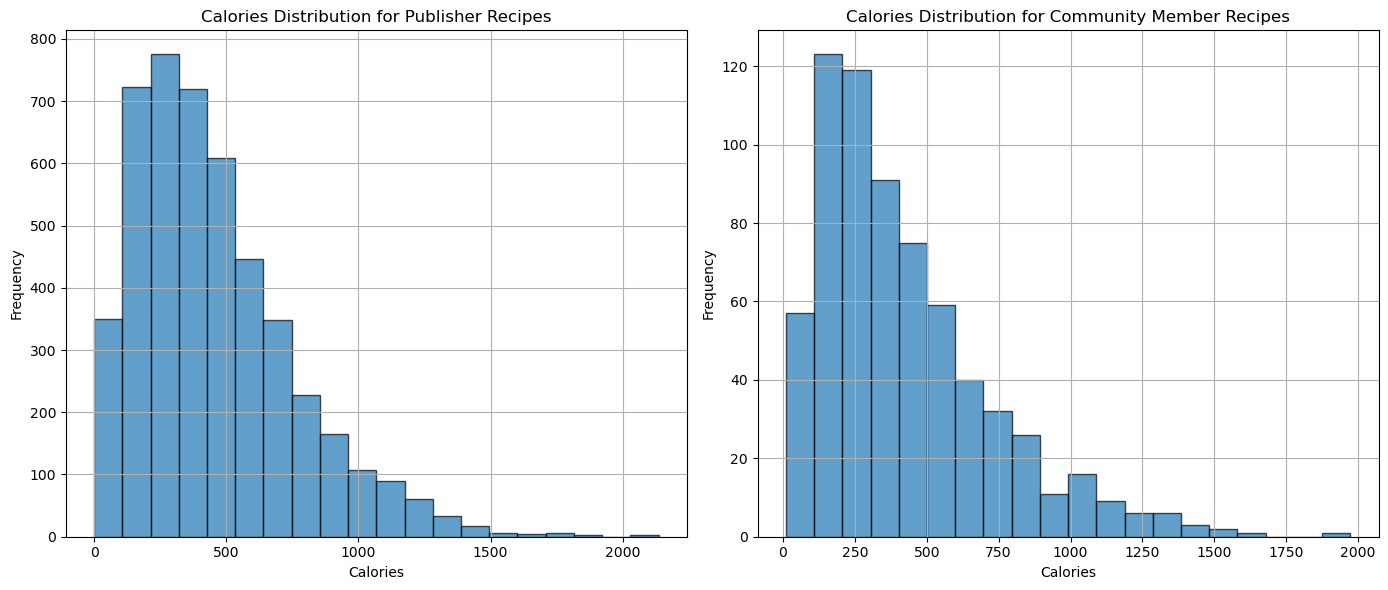

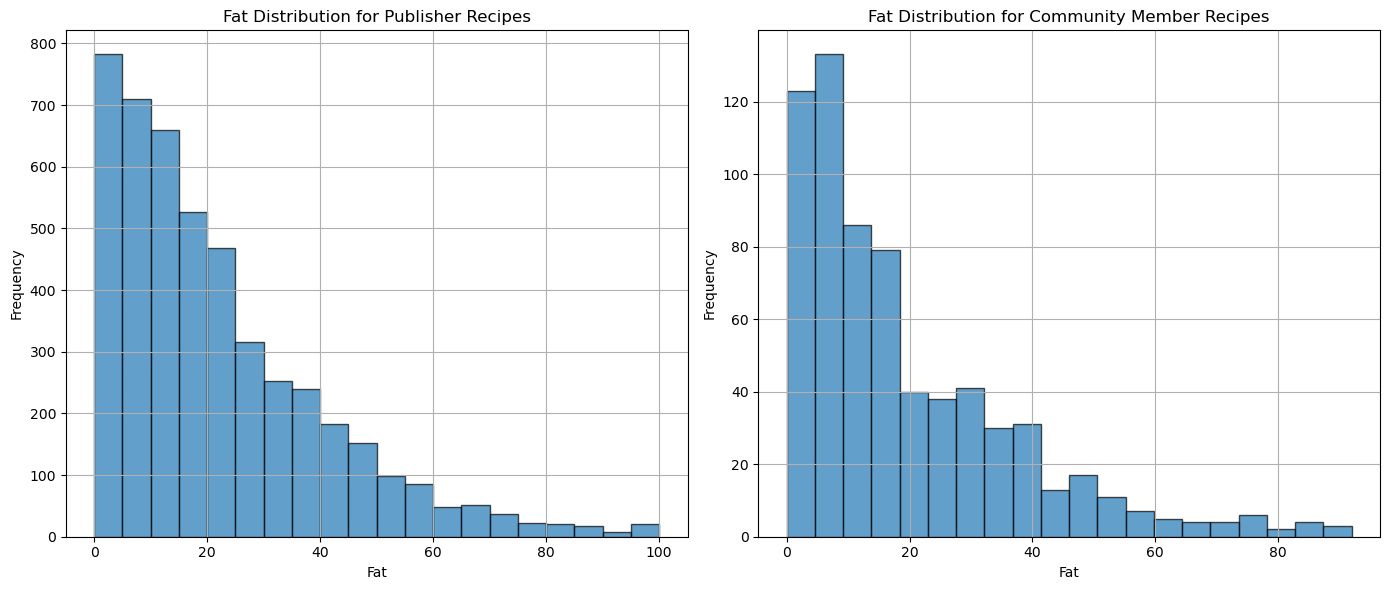

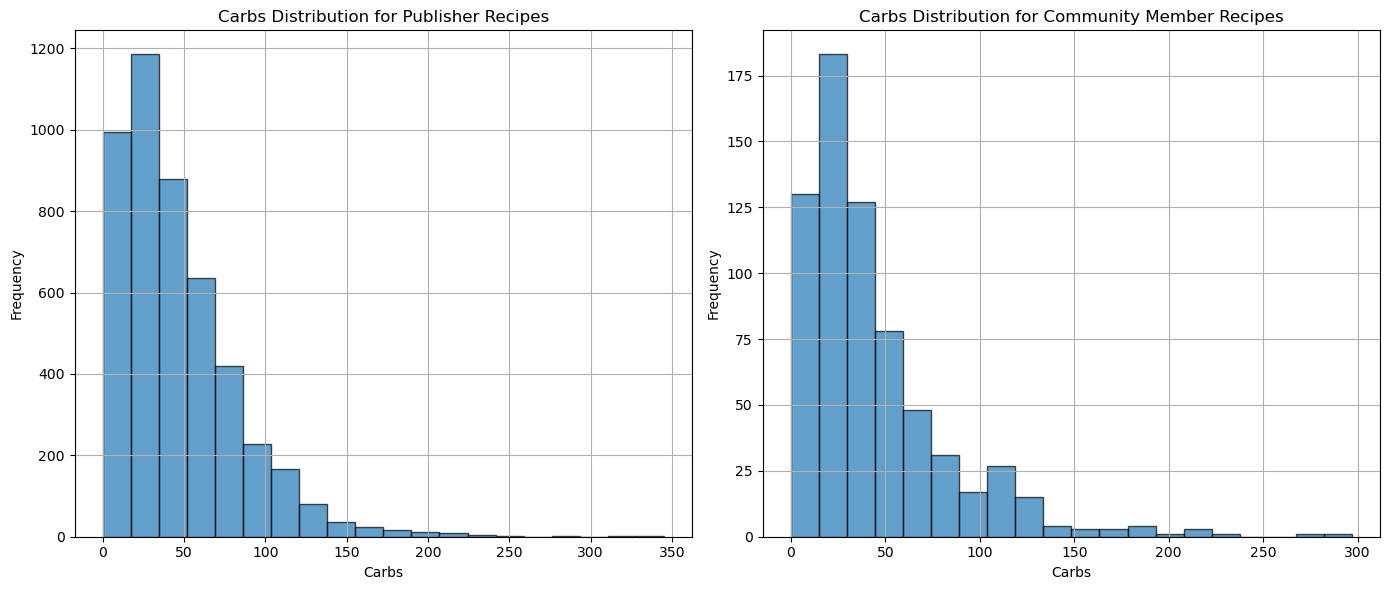

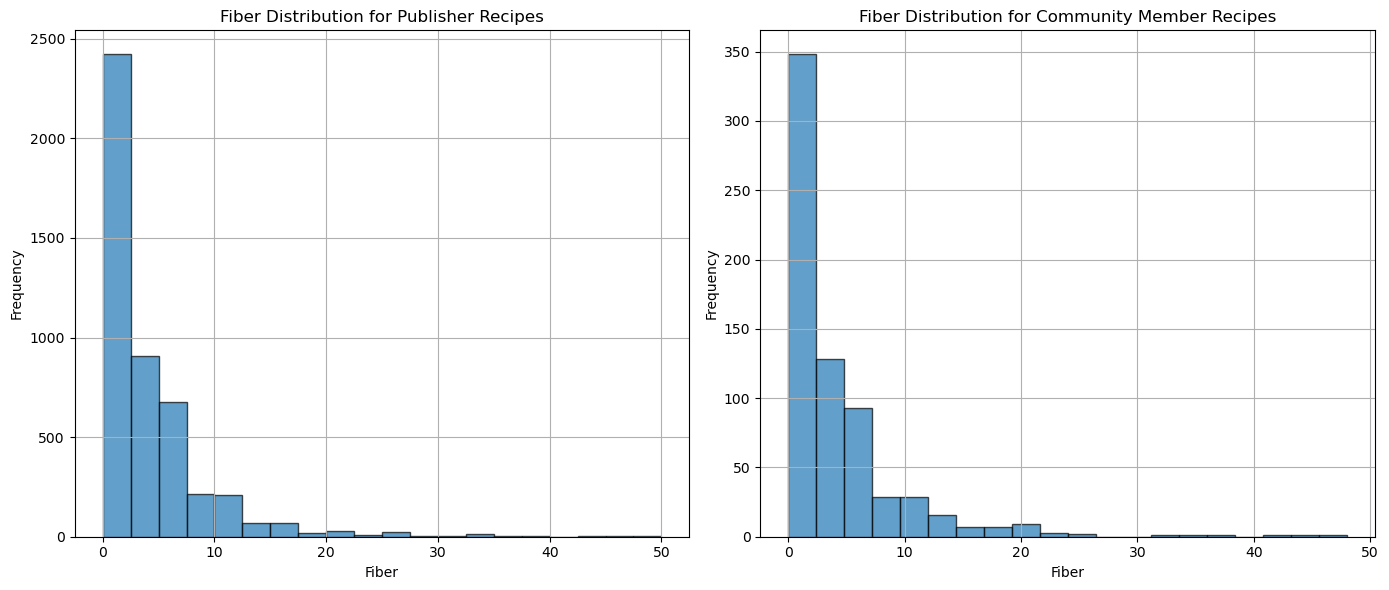

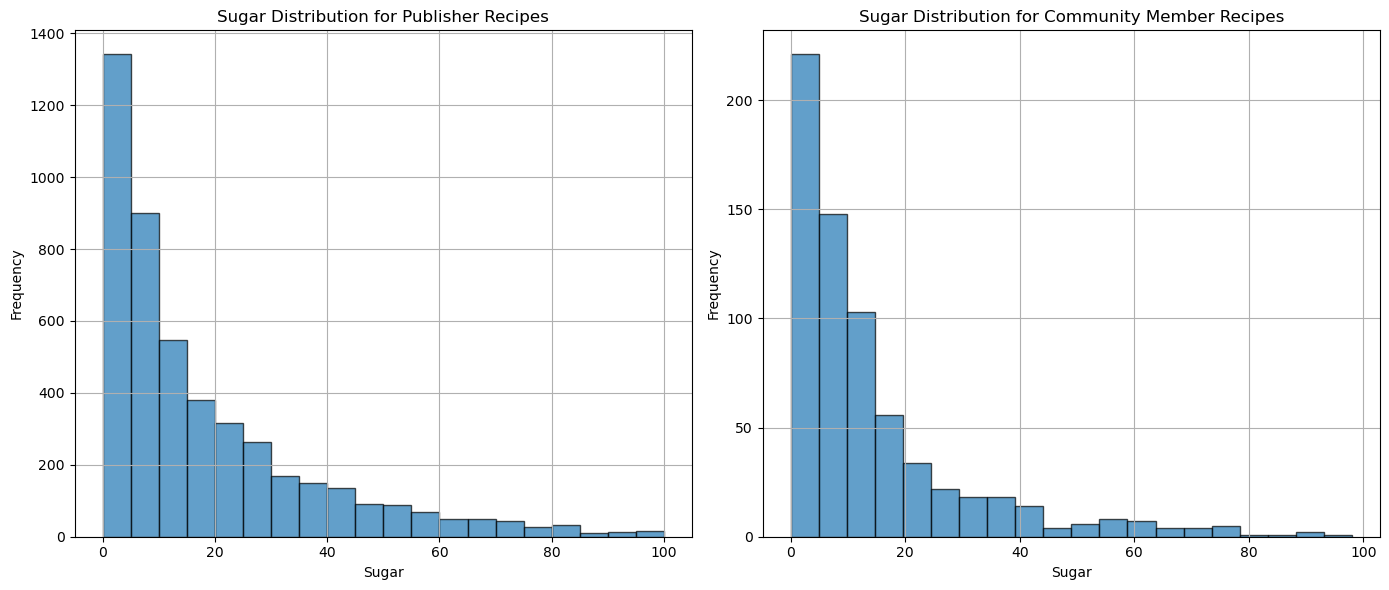

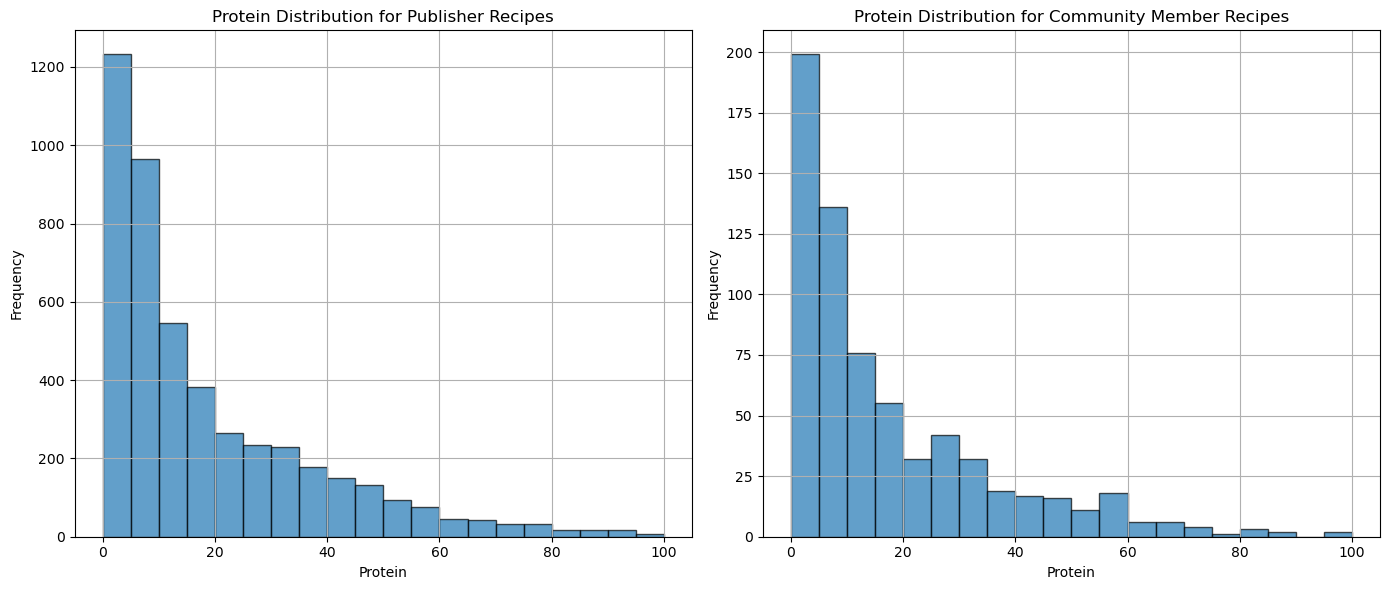

In [15]:
# Nutritional data distribution for each group
nutritional_columns = ['Calories', 'Fat', 'Carbs', 'Fiber', 'Sugar', 'Protein']
for col in nutritional_columns:
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.hist(publisher_recipes[col].dropna(), bins=20, edgecolor='k', alpha=0.7)
    plt.title(f'{col} Distribution for Publisher Recipes')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.hist(community_recipes[col].dropna(), bins=20, edgecolor='k', alpha=0.7)
    plt.title(f'{col} Distribution for Community Member Recipes')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

- **Calories**: Publisher recipes tend to have a broader distribution with a peak around 300-600 calories, while community recipes generally have lower calorie counts, with a peak around 200-400 calories.
- **Fat**: Similar to calories, publisher recipes show a wider range of fat content, while community recipes have a tighter distribution.
- **Carbs**: Both types show a right-skewed distribution, but publisher recipes again have a wider range.
- **Fiber**: Most recipes, in both groups, contain low fiber content, with a steep drop-off after 10g.
- **Sugar**: Publisher recipes tend to have more sugar content, but both groups have a peak around 5-10g.
- **Protein**: Publisher recipes generally have higher protein content, with a broader distribution, while community recipes tend to be concentrated around 10-30g. 

Overall, publisher recipes show more diversity in nutritional values, suggesting a broader range of ingredients and preparation methods. Community recipes are more consistent and generally lower in these nutritional values.

### Popular ingredients

In [16]:
# List of common spices and ingredients to exclude
exclude_patterns = [
    r'salt', r'pepper', r'olive oil', r'water', r'sugar', r'garlic', 
    r'onion', r'butter', r'oil', r'vanilla', r'spray', r'soy',
    r'baking soda', r'flour', r'milk', r'egg', r'eggs', r'paprika', r'juice', r'powder', r'seeds', r'oregano', r'cornstarch', r'leaves'
]

In [17]:
# Function to normalize ingredient names by removing amounts and units
def normalize_ingredient(ingredient):
    # Remove common fractions
    ingredient = re.sub(r'\b(½|¼|¾|⅓|⅔)\b', '', ingredient)
    # Remove standalone numbers and fractions
    ingredient = re.sub(r'\d+\s*/\s*\d+', '', ingredient)  # Remove fractions
    ingredient = re.sub(r'\d+', '', ingredient)  # Remove standalone numbers
    # Remove units
    ingredient = re.sub(r'\b(cup|cups|tablespoon|tablespoons|teaspoon|teaspoons|oz|ounce|ounces|lb|pound|pounds|g|grams|kg|kilograms|ml|milliliters|liter|liters)\b', '', ingredient, flags=re.IGNORECASE)
    # Remove text in parentheses
    ingredient = re.sub(r'\([^)]*\)', '', ingredient)
    # Remove punctuation
    ingredient = re.sub(r'[^\w\s]', '', ingredient)
    # Remove extra whitespace
    ingredient = ' '.join(ingredient.split())
    ingredient = ingredient.strip().lower()
    return ingredient

In [18]:
# Function to process ingredient lists and count frequency of each ingredient
def count_ingredients(recipes, exclude_patterns):
    all_ingredients = []
    for ingredients_list in recipes['Ingredients'].dropna():
        ingredients = eval(ingredients_list)  # Convert string representation of list to actual list
        normalized_ingredients = [normalize_ingredient(ingredient) for ingredient in ingredients]
        filtered_ingredients = [ingredient for ingredient in normalized_ingredients if not any(re.search(pattern, ingredient) for pattern in exclude_patterns)]
        all_ingredients.extend(filtered_ingredients)
    return Counter(all_ingredients)

In [19]:
# Count ingredients for each group
publisher_ingredients_count = count_ingredients(publisher_recipes, exclude_patterns)
community_ingredients_count = count_ingredients(community_recipes, exclude_patterns)

# Get the most common ingredients
most_common_publisher_ingredients = publisher_ingredients_count.most_common(20)
most_common_community_ingredients = community_ingredients_count.most_common(20)

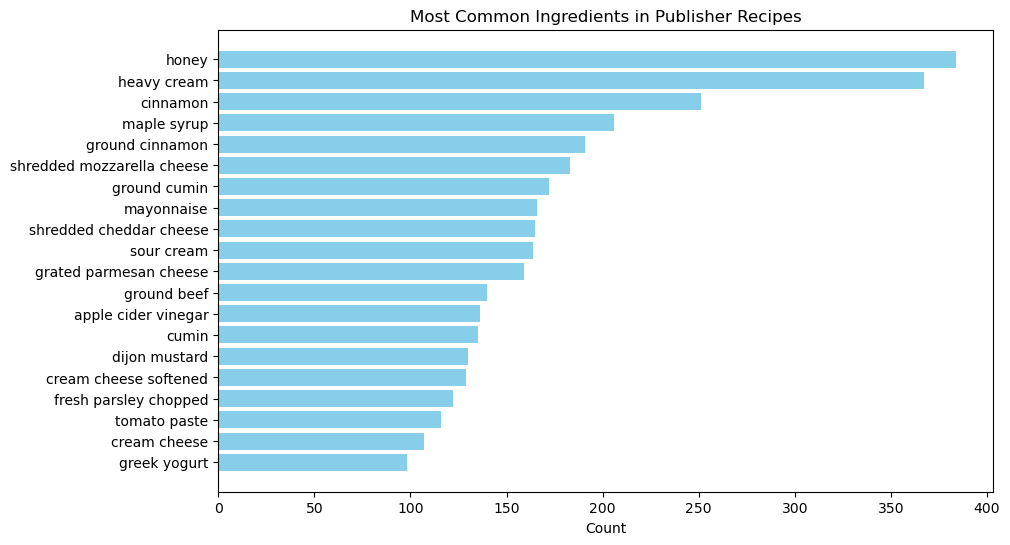

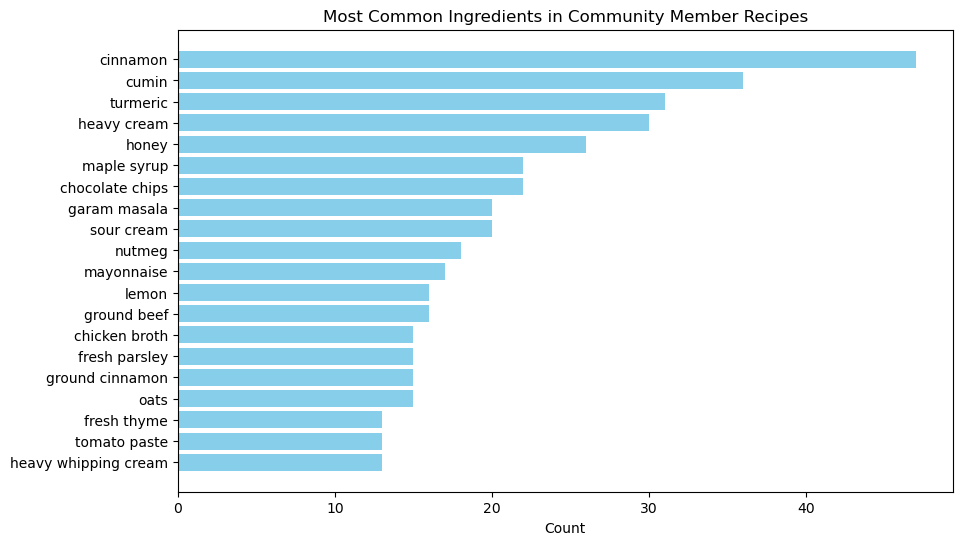

In [20]:
# Plot the most common ingredients for each group
def plot_common_ingredients(common_ingredients, title):
    ingredients, counts = zip(*common_ingredients)
    plt.figure(figsize=(10, 6))
    plt.barh(ingredients, counts, color='skyblue')
    plt.xlabel('Count')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

# Plot the most common ingredients for Publisher and Community Member recipes
plot_common_ingredients(most_common_publisher_ingredients, 'Most Common Ingredients in Publisher Recipes')
plot_common_ingredients(most_common_community_ingredients, 'Most Common Ingredients in Community Member Recipes')

- **Publisher Recipes**:
  - **Diverse and Rich Ingredients**: The most frequent ingredients include honey, heavy cream, cinnamon, and a variety of cheeses such as mozzarella and cheddar. These selections indicate a focus on rich and comforting dishes, appealing to a broad audience.
  - **Wide Flavor Range**: The usage of ingredients like sour cream, cumin, and Dijon mustard points to a diverse range of flavors, from creamy to spicy, suggesting these recipes cater to varied tastes.

- **Community Member Recipes**:
  - **Spice and Flavor-Focused**: Ingredients like cinnamon, cumin, turmeric, and heavy cream are common, showcasing a preference for bold, traditional flavors. Chocolate chips and honey also suggest a blend of sweet and rich culinary creations.
  - **Diverse Culinary Influences**: The presence of ingredients such as garam masala and fresh parsley highlights the varied influences and personal creativity evident in these recipes.

These observations suggest that publisher recipes emphasize universally appealing, rich flavors, while community member recipes feature a mix of traditional spices and personalized touches.

### Number of steps and ingredients

In [21]:
# Function to count the number of steps in the preparation steps
def count_steps(preparation_steps):
    try:
        steps = eval(preparation_steps)
        return len(steps)
    except:
        return 0

# Function to count the number of ingredients
def count_ingredients(ingredients):
    try:
        ingredients_list = eval(ingredients)
        return len(ingredients_list)
    except:
        return 0

In [22]:
# Add new columns for the number of steps and the number of ingredients
df_recipes['Number of Steps'] = df_recipes['Preparation Steps'].apply(count_steps)
df_recipes['Number of Ingredients'] = df_recipes['Ingredients'].apply(count_ingredients)

# Split the data into Publisher and Community Member recipes
publisher_recipes = df_recipes[df_recipes['Role'] == 0]
community_recipes = df_recipes[df_recipes['Role'] == 1]

# Calculate basic statistics for the number of steps and number of ingredients
publisher_stats = publisher_recipes[['Number of Steps', 'Number of Ingredients']].describe()
community_stats = community_recipes[['Number of Steps', 'Number of Ingredients']].describe()

# Print the statistics
print("Publisher Recipes Statistics:")
print(publisher_stats)
print("\nCommunity Member Recipes Statistics:")
print(community_stats)

Publisher Recipes Statistics:
       Number of Steps  Number of Ingredients
count      5209.000000            5209.000000
mean          9.554041              11.815128
std           3.878756               6.178368
min           2.000000               1.000000
25%           7.000000               7.000000
50%           9.000000              11.000000
75%          12.000000              15.000000
max          36.000000              61.000000

Community Member Recipes Statistics:
       Number of Steps  Number of Ingredients
count       736.000000             736.000000
mean          7.826087              11.355978
std           3.064774               5.133157
min           3.000000               2.000000
25%           6.000000               8.000000
50%           7.000000              11.000000
75%           9.000000              14.000000
max          25.000000              36.000000


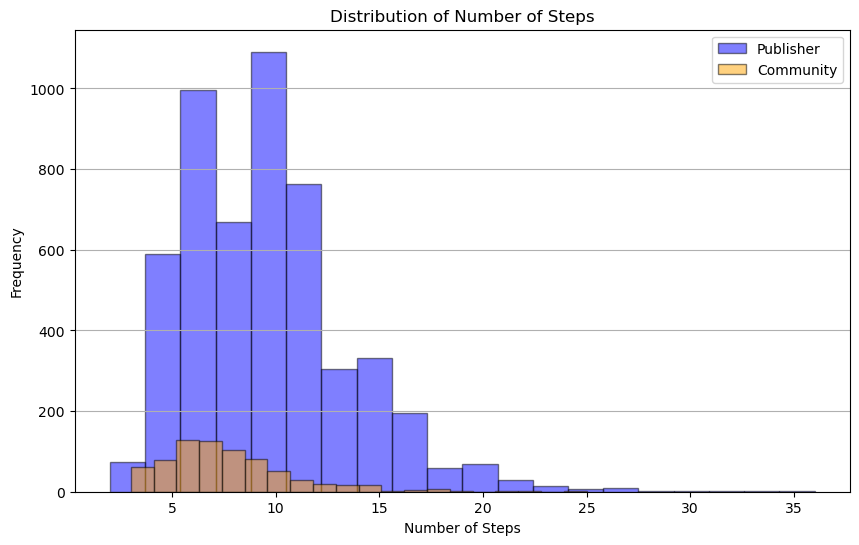

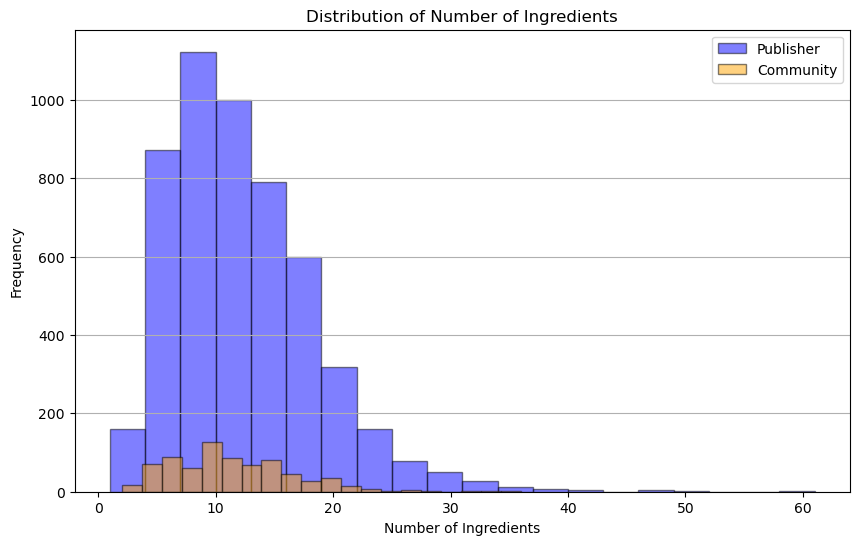

In [23]:
def plot_distribution(data, column, title):
    plt.figure(figsize=(10, 6))
    plt.hist(data[column], bins=20, alpha=0.5, label='Publisher', color='blue', edgecolor='black')
    plt.hist(community_recipes[column], bins=20, alpha=0.5, label='Community', color='orange', edgecolor='black')
    plt.title(title)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(axis='y')
    plt.show()

# Plot distributions
plot_distribution(publisher_recipes, 'Number of Steps', 'Distribution of Number of Steps')
plot_distribution(publisher_recipes, 'Number of Ingredients', 'Distribution of Number of Ingredients')

**Distribution of Number of Steps**:
   - Publisher recipes show a broader distribution with a higher peak at around 8-10 steps.
   - Community member recipes have a narrower distribution, with a peak at around 6-8 steps.

**Distribution of Number of Ingredients**:
   - Publisher recipes use a higher number of ingredients on average, with a peak around 10-12 ingredients.
   - Community member recipes have a similar peak but with a slightly lower average number of ingredients. 

These visualizations highlight the general complexity and ingredient richness of publisher recipes compared to the more straightforward and ingredient-efficient community member recipes.

### Recipe Tags

In [24]:
# Function to count tags
def count_tags(recipes):
    all_tags = []
    for tags_list in recipes['Tags'].dropna():
        tags = tags_list.split(',')
        tags = [tag.strip().lower() for tag in tags]
        all_tags.extend(tags)
    return Counter(all_tags)

# Count tags for each group
publisher_tags_count = count_tags(publisher_recipes)
community_tags_count = count_tags(community_recipes)

In [25]:
# Get the most common tags
most_common_publisher_tags = publisher_tags_count.most_common(10)
most_common_community_tags = community_tags_count.most_common(10)

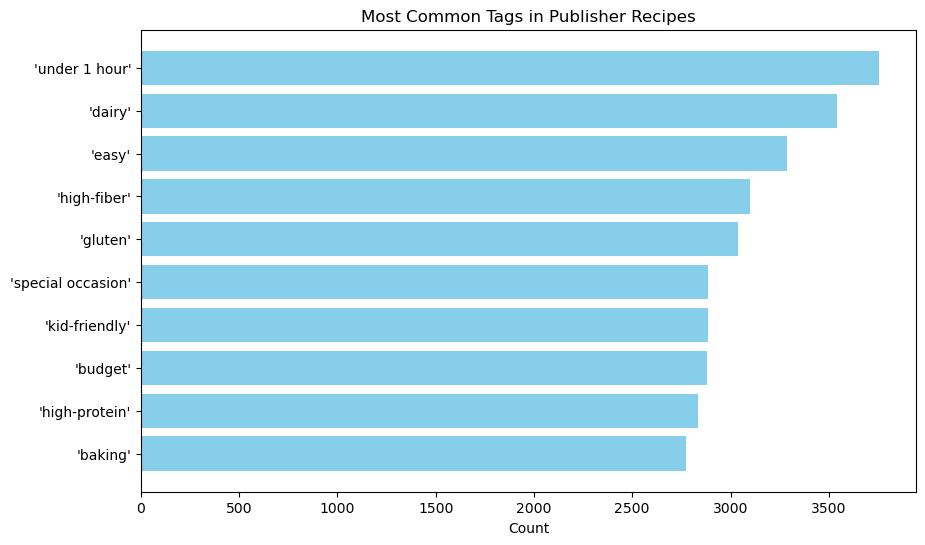

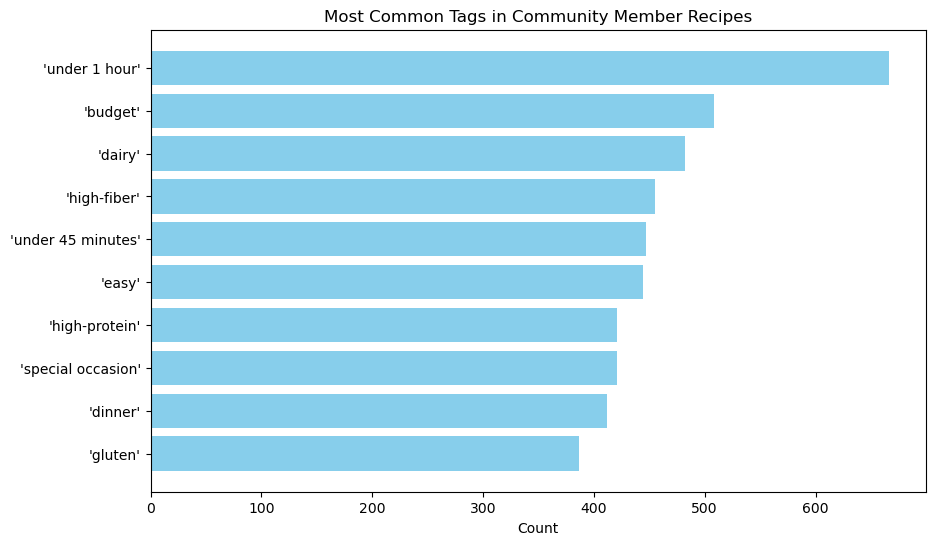

In [26]:
# Plot the most common tags for each group
def plot_common_tags(common_tags, title):
    tags, counts = zip(*common_tags)
    plt.figure(figsize=(10, 6))
    plt.barh(tags, counts, color='skyblue')
    plt.xlabel('Count')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

    # Plot the most common tags for Publisher and Community Member recipes
plot_common_tags(most_common_publisher_tags, 'Most Common Tags in Publisher Recipes')
plot_common_tags(most_common_community_tags, 'Most Common Tags in Community Member Recipes')

- **Commonalities**: Both publisher and community recipes continue to emphasize quick and easy options, with "under 1 hour," "dairy," "high-fiber," and "easy" tags being highly prevalent in both categories. Budget-friendly and special occasion tags are also significant across both groups.

- **Differences**: Publisher recipes still highlight a wider array of dietary tags such as "kid-friendly" and "baking," while community member recipes place more emphasis on "under 45 minutes" and "dinner." The focus on "vegetarian" tags is less pronounced in the new data.

These updates reaffirm that publisher recipes cater to a diverse audience with an emphasis on varied dietary needs, while community recipes continue to prioritize practical, time-efficient, and budget-friendly options.

### Publisher vs. Community Recipes: Key Insights Summary

Based on the detailed analysis of score distributions, cooking times, nutritional data, popular ingredients, recipe steps, and tags, the following key differences between publisher and community recipes are identified:

1. **Scores**: Publisher recipes tend to have slightly higher average scores and a more consistent quality, indicated by a tighter distribution of scores.

2. **Cooking Times**: Publisher recipes generally take longer to prepare and cook, suggesting more complex recipes. In contrast, community recipes are quicker, reflecting simpler or more accessible meal options.

3. **Nutritional Data**: Publisher recipes often contain higher calorie, fat, and protein content, likely due to richer ingredients. Community recipes, while varied, tend to focus on balanced or lighter meals.

4. **Ingredients**: Publisher recipes commonly feature ingredients like honey, heavy cream, and cinnamon, aligning with indulgent, comfort-oriented dishes. Community recipes, however, frequently use spices like cumin and turmeric, indicating a trend toward globally-inspired and flavor-rich meals.

5. **Recipe Complexity**: Publisher recipes typically have more steps and use more ingredients, contributing to their longer preparation and cooking times. Community recipes are generally simpler, which makes them more suitable for everyday cooking.

6. **Tags**: Both types of recipes emphasize convenience, with "under 1 hour" being a top tag. However, community recipes show a greater focus on budget-friendliness and shorter cooking times, while publisher recipes emphasize diverse dietary needs, such as "gluten-free" and "high-protein" options.

In summary, publisher recipes are generally more elaborate, featuring richer ingredients and longer cooking times, while community recipes are more practical, emphasizing quicker, budget-friendly meals with a focus on robust flavors and global influences.

## 3. Data preparation

In this chapter, the focus is on preparing the dataset for effective model training. Text features will be prepared for vectorization. Outliers will be detected and addressed to avoid skewing the model's performance. Missing values will be handled systematically to maintain data integrity and ensure comprehensive model training. 

### Removing columns

In [27]:
# Drop the 'Author' and 'Recipe URL' columns
df_recipes = df_recipes.drop(columns=['Author', 'Recipe URL'])

### Flatten ingredients, instructions and tags lists

In [28]:
# Define the function to flatten ingredients
def flatten_ingredients(ingredients_list):
    if isinstance(ingredients_list, str):
        ingredients_list = eval(ingredients_list)
    if isinstance(ingredients_list, list):
        flattened = [ingredient for ingredient in ingredients_list]
        return '; '.join(flattened)
    return ''

# Define the function to flatten instructions
def flatten_instructions(instructions_list):
    if isinstance(instructions_list, str):
        instructions_list = eval(instructions_list)
    if isinstance(instructions_list, list):
        steps = [instruction for instruction in instructions_list]
        return ' '.join(steps)
    return ''

# Define the function to flatten tags
def flatten_tags(tags_list):
    if isinstance(tags_list, str):
        tags_list = eval(tags_list)
    if isinstance(tags_list, list):
        flattened = [tag for tag in tags_list]
        return '; '.join(flattened)
    return ''

# Apply the functions to the DataFrame
df_recipes['Ingredients'] = df_recipes['Ingredients'].apply(flatten_ingredients)
df_recipes['Preparation Steps'] = df_recipes['Preparation Steps'].apply(flatten_instructions)
df_recipes['Tags'] = df_recipes['Tags'].apply(flatten_tags)

df_recipes

,Recipe Title,Role,Score,Total Time,Prep Time,Cook Time,Ingredients,Preparation Steps,Calories,Fat,Carbs,Fiber,Sugar,Protein,Tags,Number of Steps,Number of Ingredients
0,Roasted Moroccan Carrots With Baba Ganoush,1,NaN,30.0,10.0,20.0,"1 bunch dutch carrots, washed and tops trimmed...",Place carrots on a baking dish lined with baki...,72.0,4.0,8.0,2.0,2.0,2.0,Meal; Dinner; Weeknight; Kosher; Halal; Budget...,4,8
1,Edamame Truffle Dumplings In Miso Broth,1,NaN,70.0,40.0,30.0,1 package frozen shelled edamame; 2 tablespoon...,Cook the frozen edamame according the package ...,413.0,16.0,49.0,6.0,3.0,18.0,Cuisine; Asian; Japanese; Soy; Gluten; Allerge...,11,19
2,Grilled Napa Cabbage Fattoush Salad,1,NaN,40.0,20.0,20.0,"1 head medium napa cabbage; 1 small red onion,...",Preheat the grill and preheat the oven to 375°...,430.0,29.0,32.0,2.0,6.0,9.0,Cuisine; European; Mediterranean; Kosher; Dair...,9,20
3,Roasted Tomato Basil Soup,0,91.0,25.0,5.0,20.0,"1 tablespoon olive oil; 1 yellow onion, diced;...","In a large pot over medium heat, combine the o...",48.0,0.0,9.0,1.0,2.0,1.0,Meal; Dinner; Soups; Budget; High-Fiber; Low-F...,6,13
4,Tuna Salad With Roasted Veggies,0,96.0,35.0,15.0,20.0,"1 cup green beans (360 g), trimmed; 2 cups bab...",Preheat the oven to 375˚F (190˚C). On a baking...,576.0,19.0,51.0,7.0,11.0,49.0,Meal; Lunch; Salads; Dairy; Fish; European; Di...,10,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6599,Carrot Cake Granola Balls,2,95.0,NaN,NaN,NaN,1 ¼ cups oats (125 g); ⅖ cup walnuts (40 g); 1...,"Add oats, walnuts and ground almonds to a larg...",167.0,10.0,16.0,2.0,5.0,4.0,Meal; Dinner; Weeknight; Budget; Peanuts; Tree...,7,8
6600,Date-Nut Energy Balls,1,NaN,NaN,NaN,NaN,1 cup whole almonds (125 g); 1 cup date (175 g...,Put all ingredients in a food processor and pr...,80.0,5.0,7.0,1.0,4.0,2.0,Meal; Snacks; Kosher; Halal; Tree nuts; High-F...,4,4
6601,Cheesy Pretzel Ring Dip,0,95.0,60.0,30.0,30.0,32 oz pizza dough (910 g); 5 cups water (1 ¼ L...,Preheat the oven to 425°F (220°C). Cut pizza d...,418.0,23.0,36.0,1.0,2.0,15.0,Seasonal; Occasion; Party; Budget; Dairy; Glut...,14,10
6602,Pigs In A Blanket Stadium,0,90.0,165.0,30.0,135.0,"4 sheets puff pastry, chilled; 2 eggs, beaten;...",Preheat oven to 350°F (180°C). Roll out the pu...,531.0,44.0,16.0,0.0,0.0,17.0,Seasonal; Occasion; Game Day; Dairy; Gluten; E...,14,6


### Handle outliers

Outliers can significantly affect the performance of machine learning models. Many algorithms, particularly those based on distance metrics (e.g., K-Nearest Neighbors, Support Vector Machines) and linear models (e.g., Linear Regression, Logistic Regression), are sensitive to outliers. These algorithms can produce biased or skewed results when trained on data containing outliers.

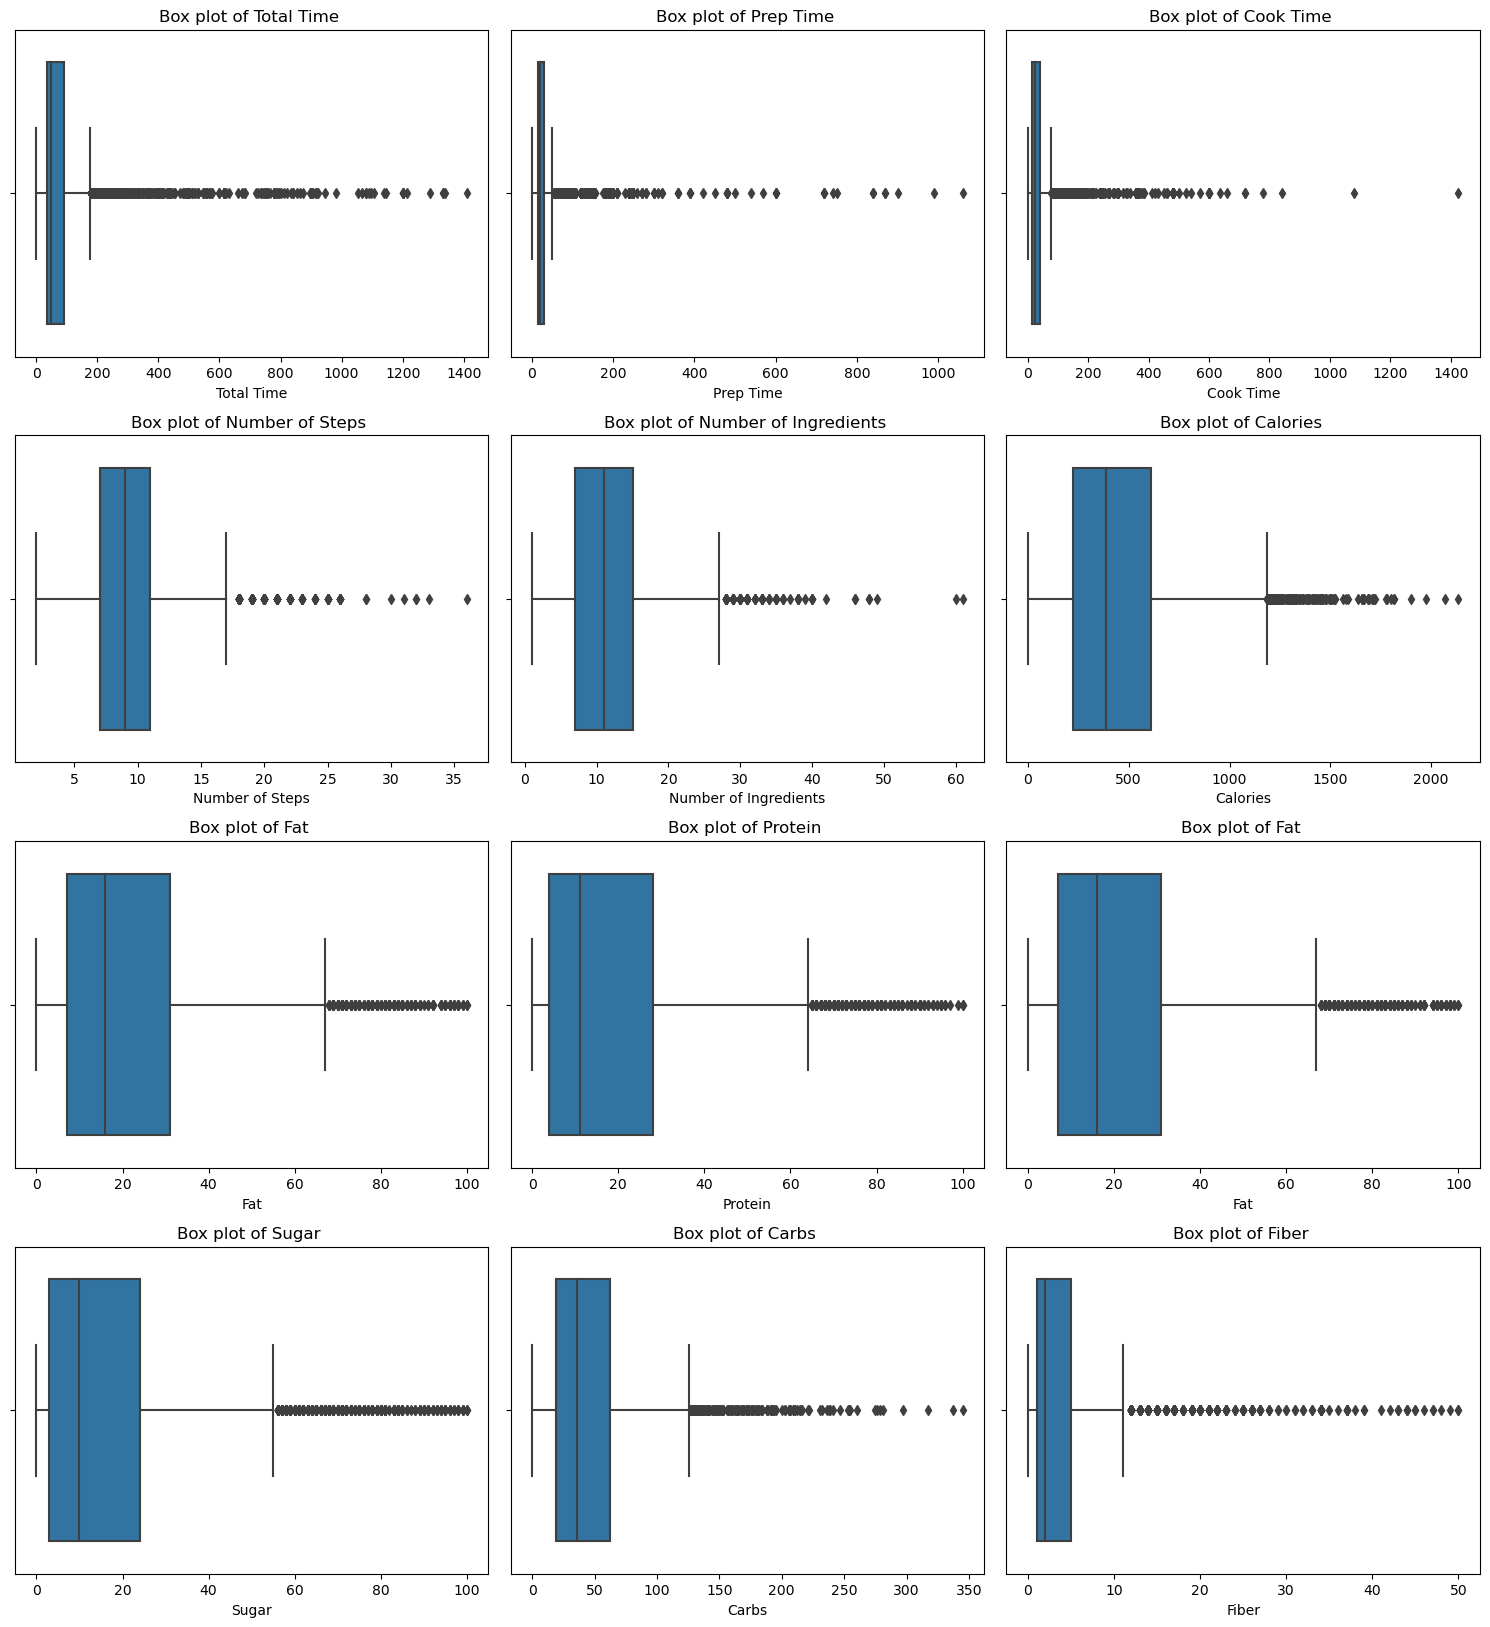

In [29]:
# List of columns to visualize
selected_columns = [
    'Total Time', 'Prep Time', 'Cook Time', 'Number of Steps', 'Number of Ingredients',
    'Calories', 'Fat', 'Protein', 'Fat', 'Sugar', 'Carbs', 'Fiber'
]

# Function to visualize data with box plots
def visualize_data(df, columns, title):
    plt.figure(figsize=(15, 20))
    for i, col in enumerate(columns, 1):
        plt.subplot(len(columns) // 3 + 1, 3, i)
        sns.boxplot(x=df[col])
        plt.title(f'Box plot of {col} {title}')
    plt.tight_layout()
    plt.show()

# Visualize initial data
visualize_data(df_recipes, selected_columns, '')

In [30]:
# Cap outliers using more realistic bounds for cooking times
def cap_outliers(df, cols, upper_bounds=None):
    for col in cols:
        if upper_bounds and col in upper_bounds:
            upper_bound = upper_bounds[col]
            df.loc[df[col] > upper_bound, col] = upper_bound
        else:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df.loc[df[col] < lower_bound, col] = lower_bound
            df.loc[df[col] > upper_bound, col] = upper_bound
    return df

# Define realistic upper bounds for time-related columns
upper_bounds = {
    'cook_time': 180,  # 3 hours
    'prep_time': 120,  # 2 hours
    'total_time': 300  # 5 hours
}

# Cap outliers in the selected columns
df_recipes = cap_outliers(df_recipes, selected_columns, upper_bounds)

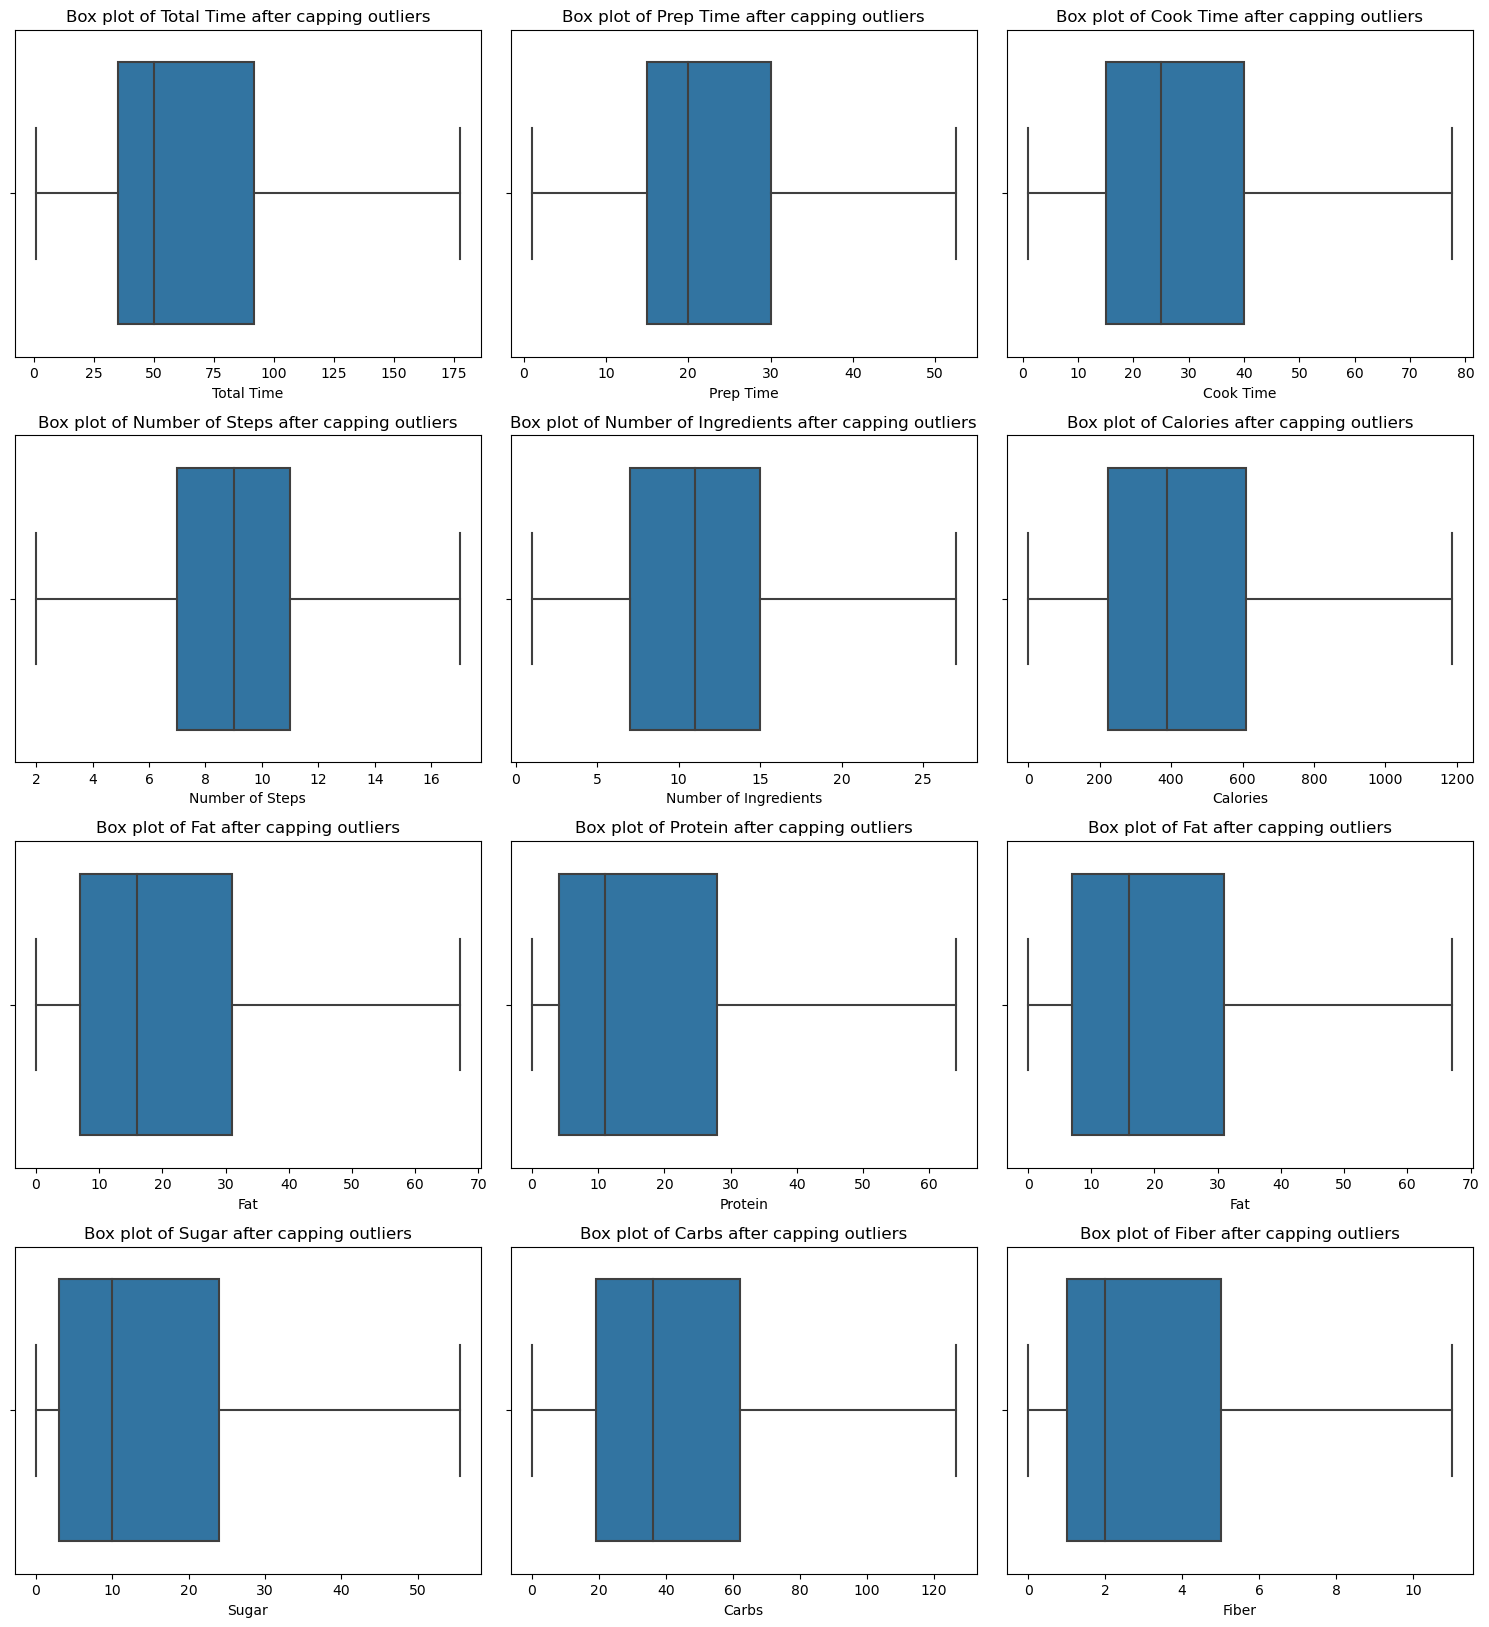

In [31]:
# Visualize data after capping outliers
visualize_data(df_recipes, selected_columns, 'after capping outliers')

In [32]:
df_recipes.describe()

,Role,Score,Total Time,Prep Time,Cook Time,Calories,Fat,Carbs,Fiber,Sugar,Protein,Number of Steps,Number of Ingredients
count,6604.000000,5144.000000,5397.000000,5408.000000,5408.000000,5982.000000,5982.000000,5982.000000,5982.000000,5982.000000,5982.000000,6604.000000,6604.000000
mean,0.311024,89.361198,71.452937,22.588757,30.721431,446.513875,20.843029,44.279338,3.396523,16.048980,17.976596,9.208813,11.541187
std,0.643371,8.753421,50.910616,14.221408,21.648172,285.681853,17.506631,32.401143,3.364683,16.326905,17.774558,3.396487,5.588978
min,0.000000,15.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000
25%,0.000000,86.000000,35.000000,15.000000,15.000000,225.000000,7.000000,19.000000,1.000000,3.000000,4.000000,7.000000,7.000000
50%,0.000000,92.000000,50.000000,20.000000,25.000000,389.000000,16.000000,36.000000,2.000000,10.000000,11.000000,9.000000,11.000000
75%,0.000000,95.000000,92.000000,30.000000,40.000000,609.000000,31.000000,62.000000,5.000000,24.000000,28.000000,11.000000,15.000000
max,2.000000,100.000000,177.500000,52.500000,77.500000,1185.000000,67.000000,126.500000,11.000000,55.500000,64.000000,17.000000,27.000000


The box plots show that the outliers have been effectively capped, resulting in more compact and controlled distributions for each column. The data is now better prepared for model training.

### Handle missing values

The approach to handling missing values involves grouping recipes by categories such as Breakfast, Lunch, and Dinner, then imputing missing numerical data. This method was chosen to preserve the unique characteristics of each recipe type, ensuring that the imputed values accurately reflect the typical patterns within each group.

In [35]:
# Print columns with missing values
missing_values = df_recipes.isnull().sum()
missing_columns = missing_values[missing_values > 0]
print("Columns with missing values:\n", missing_columns)

Columns with missing values:
 Score         1460
Total Time    1207
Prep Time     1196
Cook Time     1196
Calories       622
Fat            622
Carbs          622
Fiber          622
Sugar          622
Protein        622
dtype: int64


In [36]:
# Define keywords for grouping
keywords = ['Breakfast', 'Lunch', 'Dinner', 'Desserts', 'Snacks']

# Function to categorize based on the first matching keyword
def categorize_recipe(tags):
    for keyword in keywords:
        if keyword.lower() in tags.lower():
            return keyword
    return 'Other'

# Apply the function to the Tags column
df_recipes['Categories'] = df_recipes['Tags'].apply(categorize_recipe)

# Check if any recipe belongs to more than one category
multiple_categories = df_recipes[df_recipes['Categories'].apply(len) > 1]

In [38]:
# Group by the new category and calculate summary statistics
for category in df_recipes['Categories'].unique():
    category_recipes = df_recipes[df_recipes['Categories'] == category]
    summary_stats = category_recipes.describe()
    
    # Print the summary statistics for the category
    print(f"Summary Statistics for {category} Recipes:")
    print(summary_stats)
    print("\n" + "-"*50 + "\n")
    
    # Get the total count of recipes in this category
    total_recipes = len(category_recipes)
    print(f"Total number of recipes in {category} category: {total_recipes}\n")
    
    # Check for missing values in this category
    missing_values = category_recipes.isnull().sum()
    missing_columns = missing_values[missing_values > 0]
    print(f"Missing Values in {category} Recipes (out of {total_recipes}):\n", missing_columns)
    print("\n" + "="*50 + "\n")

Summary Statistics for Lunch Recipes:
              Role        Score   Total Time    Prep Time    Cook Time  \
count  1486.000000  1132.000000  1268.000000  1268.000000  1268.000000   
mean      0.335801    91.031802    61.906546    20.831230    28.430599   
std       0.659270     8.081091    47.267970    12.882119    20.609897   
min       0.000000    21.000000     4.000000     1.000000     1.000000   
25%       0.000000    89.000000    30.000000    10.000000    15.000000   
50%       0.000000    93.000000    45.000000    15.000000    20.000000   
75%       0.000000    96.000000    75.000000    30.000000    35.000000   
max       2.000000   100.000000   177.500000    52.500000    77.500000   

          Calories          Fat        Carbs       Fiber        Sugar  \
count  1351.000000  1351.000000  1351.000000  1351.00000  1351.000000   
mean    484.499630    22.626203    43.236491     4.23168     9.460770   
std     295.170901    18.534257    32.714349     3.53548    10.753894   
min

Based on the summary statistics for each recipe category, it is recommended to use **median imputation** across all categories due to the slightly skewed distributions. The median is more robust and less affected by extreme values, making it a better choice for imputation in this context.

In [39]:
# Step 1: Filter for numeric columns
numeric_columns = df_recipes.select_dtypes(include=['number']).columns

# Calculate the median for each category based on numeric columns only
category_medians = df_recipes.groupby('Categories')[numeric_columns].median()

# Step 2: Define a function to impute missing values
def impute_missing_values(row):
    category = row['Categories']
    for column in numeric_columns:
        if pd.isnull(row[column]):
            row[column] = category_medians.loc[category, column]
    return row

# Apply the imputation function to the DataFrame
df_recipes = df_recipes.apply(impute_missing_values, axis=1)

In [40]:
# Check if all missing values are imputed
missing_values_after = df_recipes.isnull().sum()
print("Missing values after imputation:\n", missing_values_after)

Missing values after imputation:
 Recipe Title             0
Role                     0
Score                    0
Total Time               0
Prep Time                0
Cook Time                0
Ingredients              0
Preparation Steps        0
Calories                 0
Fat                      0
Carbs                    0
Fiber                    0
Sugar                    0
Protein                  0
Tags                     0
Number of Steps          0
Number of Ingredients    0
Categories               0
dtype: int64


### TEST

In [ ]:
# Select the columns for KNN imputation
numerical_columns = ['Score', 'Total Time', 'Prep Time', 'Cook Time', 'Fat', 'Calories', 'Sugar', 'Carbs', 'Fiber', 'Protein']

# Ensure all selected columns are numeric
df_recipes[numerical_columns] = df_recipes[numerical_columns].apply(pd.to_numeric, errors='coerce')

In [ ]:
# Function to apply KNN imputation for the specified columns
def knn_imputation(df, columns_to_impute, n_neighbors=5):
    # Replace zero values in the specified columns with NaN for imputation
    df[columns_to_impute] = df[columns_to_impute].replace(0, np.nan)
    
    # Apply KNN imputation only to the specified columns
    imputer = KNNImputer(n_neighbors=n_neighbors)
    df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])
    
    return df

In [ ]:
param_grids = {
    'Linear Regression': {
        'model__fit_intercept': [True, False]
    },
    'Random Forest': {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    'Gradient Boosting': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    },
    'SVR': {
        'model__kernel': ['linear', 'rbf'],
        'model__C': [0.1, 1, 10],
        'model__gamma': ['scale', 'auto']
    },
    'XGBoost': {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [3, 5, 7],
        'model__learning_rate': [0.01, 0.1, 0.2]
    }
}

In [ ]:
# Define the models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'SVR': SVR(),
    'XGBoost': XGBRegressor()
}

In [ ]:
# Define the vectorizer
vectorizer = TfidfVectorizer()

# Feature numbers and KNN neighbors to test
feature_numbers = [5, 10, 20, 50, 100, 200]
knn_neighbors = [3, 5, 7]

In [ ]:
best_models = {}
best_scores = {}

In [ ]:
# Function to run the experiment
def run_experiment(X_train, y_train, X_test, y_test, feature_num):
    for model_name in models:
        print(f"Training {model_name}...")
        vectorizer_ing = TfidfVectorizer(max_features=feature_num)
        vectorizer_ins = TfidfVectorizer(max_features=feature_num)
        vectorizer_tag = TfidfVectorizer(max_features=feature_num)
        
        # Fit and transform the text data
        X_train_ing = vectorizer_ing.fit_transform(X_train['Ingredients'])
        X_train_ins = vectorizer_ins.fit_transform(X_train['Preparation Steps'])
        X_train_tag = vectorizer_tag.fit_transform(X_train['Tags'])
        
        X_test_ing = vectorizer_ing.transform(X_test['Ingredients'])
        X_test_ins = vectorizer_ins.transform(X_test['Preparation Steps'])
        X_test_tag = vectorizer_tag.transform(X_test['Tags'])
        
        # Concatenate the text features into a single matrix
        X_train_text = hstack([X_train_ing, X_train_ins, X_train_tag])
        X_test_text = hstack([X_test_ing, X_test_ins, X_test_tag])
        
        # Standardize the numerical features
        scaler = StandardScaler(with_mean=False)
        X_train_num = scaler.fit_transform(X_train[numerical_columns])
        X_test_num = scaler.transform(X_test[numerical_columns])
        
        # Combine text and numerical features
        X_train_combined = hstack([X_train_text, X_train_num])
        X_test_combined = hstack([X_test_text, X_test_num])
        
        pipeline = Pipeline([
            ('model', models[model_name])
        ])
        
        grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2, return_train_score=True)
        grid_search.fit(X_train_combined, y_train)
        
        best_models[model_name] = grid_search.best_estimator_
        best_scores[model_name] = grid_search.best_score_

        # Evaluate the best model on the test set
        y_pred = best_models[model_name].predict(X_test_combined)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        print(f"{model_name} MSE: {mse}, R²: {r2}")
        print(f"Best Parameters for {model_name}: {grid_search.best_params_}")

In [ ]:
# Split the data into publisher and community member recipes
publisher_recipes = df_recipes[df_recipes['Role'] == 0]
community_recipes = df_recipes[df_recipes['Role'] == 1]

In [ ]:
# Run the experiment for publisher recipes
print("Running experiments for Publisher Recipes")
for feature_num in feature_numbers:
    for n_neighbors in knn_neighbors:
        print(f"\nRunning experiment with {feature_num} features and {n_neighbors} KNN neighbors...\n")
        publisher_recipes_imputed = knn_imputation(publisher_recipes.copy(), numerical_columns, n_neighbors=n_neighbors)
        
        X = publisher_recipes_imputed[['Ingredients', 'Preparation Steps', 'Tags', *numerical_columns]]
        y = publisher_recipes_imputed['Score']
        
        # Split the dataset
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Run the experiment
        run_experiment(X_train, y_train, X_test, y_test, feature_num)

In [ ]:
# Run the experiment for community member recipes
print("Running experiments for Community Member Recipes")
for feature_num in feature_numbers:
    for n_neighbors in knn_neighbors:
        print(f"\nRunning experiment with {feature_num} features and {n_neighbors} KNN neighbors...\n")
        community_recipes_imputed = knn_imputation(community_recipes.copy(), numerical_columns, n_neighbors=n_neighbors)
        
        X = community_recipes_imputed[['Ingredients', 'Preparation Steps', 'Tags', *numerical_columns]]
        y = community_recipes_imputed['Score']
        
        # Split the dataset
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Run the experiment
        run_experiment(X_train, y_train, X_test, y_test, feature_num)

In [ ]:
import pickle 
# Save the trained models to disk
def save_models(models, filename):
    with open(filename, 'wb') as file:
        pickle.dump(models, file)

In [ ]:
# Example usage:
save_models(best_models, 'best_models_publisher.pkl')
# Example usage:
save_models(best_models, 'best_models_community.pkl')

### Handle missing values

In [ ]:
# Function to apply KNN imputation for the specified columns
def knn_imputation(df, columns_to_impute):
    # Replace zero values in the specified columns with NaN for imputation
    df[columns_to_impute] = df[columns_to_impute].replace(0, np.nan)
    
    # Check for missing values before imputation
    missing_values_before = df[columns_to_impute].isnull().sum()
    print("Missing values before imputation:\n", missing_values_before)
    
    # Apply KNN imputation only to the specified columns
    imputer = KNNImputer(n_neighbors=5)
    df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])
    
    return df

# Select the columns for KNN imputation
numerical_columns = ['Score', 'Total Time', 'Prep Time', 'Cook Time', 'Fat', 'Calories', 'Sugar', 'Carbs', 'Fiber', 'Protein']

# Ensure all selected columns are numeric
df_recipes[numerical_columns] = df_recipes[numerical_columns].apply(pd.to_numeric, errors='coerce')

# Apply KNN imputation to numerical columns
df_recipes = knn_imputation(df_recipes, numerical_columns)

# Verify if there are still missing values
remaining_nans = df_recipes[numerical_columns].isnull().sum()
print("\nRemaining NaNs after imputation:\n", remaining_nans)

In [ ]:
df_recipes.info()

In [ ]:
# Filter rows with missing titles
missing_titles = df_recipes[df_recipes['Recipe Title'].isnull()]

# Display rows with missing titles
print(missing_titles)

The rows are empty and will be removed from the dataframe.

In [ ]:
# Remove rows with missing recipe titles
df_recipes = df_recipes.dropna(subset=['Recipe Title'])

# Verify that rows with missing titles have been removed
print(df_recipes.info())

### Data vecotrization

In [ ]:
df_recipes

In [ ]:
# Create a copy of df_merge for numerical processing
df_numerical = df_recipes.copy()

In [ ]:
# List of text features to vectorize
text_features = ['Recipe Title', 'Ingredients', 'Preparation Steps', 'Tags']

# Function to vectorize text features
def vectorize_text_features(df, text_features):
    vectorizers = {feature: TfidfVectorizer(max_features=20, stop_words='english') for feature in text_features}
    for feature in text_features:
        tfidf_matrix = vectorizers[feature].fit_transform(df[feature].fillna('')).toarray()
        tfidf_df = pd.DataFrame(tfidf_matrix, columns=[f'{feature}_tfidf_{i}' for i in range(tfidf_matrix.shape[1])])
        tfidf_df.index = df.index  # Ensure the indices match
        df = pd.concat([df, tfidf_df], axis=1)
    df.drop(columns=text_features, inplace=True)
    return df, vectorizers

# Vectorize the text features
df_numerical, vectorizers = vectorize_text_features(df_numerical, text_features)

In [ ]:
df_numerical

The summary statistics show that the numerical columns have been successfully standardized, with means close to 0 and standard deviations close to 1. This is expected after applying the StandardScaler.

### Define models and parameters grid

In [ ]:
# Define the parameter grids
param_grids = {
    'Linear Regression': {
        'model__fit_intercept': [True, False],
        'model__normalize': [True, False]
    },
    'Random Forest': {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    'Gradient Boosting': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    },
    'SVR': {
        'model__kernel': ['linear', 'rbf'],
        'model__C': [0.1, 1, 10],
        'model__gamma': ['scale', 'auto']
    },
    'XGBoost': {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [3, 5, 7],
        'model__learning_rate': [0.01, 0.1, 0.2]
    }
}

## 4. Model training and evaluation

### 4.1 Baseline models

In [ ]:
# Split into publisher-curated and user-generated subsets
publisher_recipes = df_numerical[df_numerical['is_community'] == 0]
user_recipes = df_numerical[df_numerical['is_community'] == 1]

In [ ]:
# Perform 80/20 split for each subset
train_publisher, test_publisher = train_test_split(publisher_recipes, test_size=0.2, random_state=42)
train_user, test_user = train_test_split(user_recipes, test_size=0.2, random_state=42)

In [ ]:
# Define feature columns (all features except 'score' and 'is_community')
all_feature_columns = df_numerical.columns.drop(['score', 'is_community'])

In [ ]:
# Function to train and evaluate a model
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

##### grid search

In [ ]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

In [ ]:
# Prepare results dictionary
results = []

# Train and evaluate models for publisher-curated recipes
for model_name, model in models.items():
    mse, r2 = train_and_evaluate_model(model, train_publisher[all_feature_columns], train_publisher['score'], test_publisher[all_feature_columns], test_publisher['score'])
    results.append({'Model': model_name, 'Dataset': 'Publisher-Curated Recipes', 'MSE': mse, 'R²': r2})

# Train and evaluate models for user-generated recipes
for model_name, model in models.items():
    mse, r2 = train_and_evaluate_model(model, train_user[all_feature_columns], train_user['score'], test_user[all_feature_columns], test_user['score'])
    results.append({'Model': model_name, 'Dataset': 'User-Generated Recipes', 'MSE': mse, 'R²': r2})

In [ ]:
# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results)

# Display results
print(results_df)


| Model               | Dataset                    | MSE       | R²       |
|---------------------|----------------------------|-----------|----------|
| Linear Regression   | Publisher-Curated Recipes  | 0.549459  | 0.418552 |
| Linear Regression   | User-Generated Recipes     | 1.346859  | -0.055192|
| Random Forest       | Publisher-Curated Recipes  | 0.044056  | 0.953379 |
| Random Forest       | User-Generated Recipes     | 0.387183  | 0.696663 |
| Gradient Boosting   | Publisher-Curated Recipes  | 0.053582  | 0.943299 |
| Gradient Boosting   | User-Generated Recipes     | 0.325095  | 0.745305 |


#### Detailed Analysis

**Linear Regression:**
- **Publisher-Curated Recipes:** MSE = 0.549459, R² = 0.418552
- **User-Generated Recipes:** MSE = 1.346859, R² = -0.055192
- Linear Regression shows moderate performance for publisher-curated recipes but struggles significantly with user-generated recipes, indicating that the linear nature of this model might not be capturing the complexity of the data.

**Random Forest:**
- **Publisher-Curated Recipes:** MSE = 0.044056, R² = 0.953379
- **User-Generated Recipes:** MSE = 0.387183, R² = 0.696663
- Random Forest performs exceptionally well with publisher-curated recipes but has a lower performance with user-generated recipes. This suggests that while it can handle more complex patterns, the variability in user-generated data presents a challenge.

**Gradient Boosting:**
- **Publisher-Curated Recipes:** MSE = 0.053582, R² = 0.943299
- **User-Generated Recipes:** MSE = 0.325095, R² = 0.745305
- Gradient Boosting shows similar trends to Random Forest, performing well on publisher-curated recipes but less so on user-generated recipes. Its iterative approach to reducing errors makes it slightly better suited to handle the complexities of user-generated data compared to Random Forest.

#### Potential Reasons for Discrepancy

1. **Data Quality and Consistency:**
   - Publisher-curated recipes are likely to be more standardized, with consistent formats and higher-quality data. This makes it easier for the model to learn and make accurate predictions.
   - User-generated recipes can vary widely in format, quality, and completeness, making it harder for the model to generalize and predict accurately. 

2. **Sample Size:**
   - If there are significantly more publisher-curated recipes in the training data, the model might be biased towards learning patterns from publisher data, leading to better performance on publisher-curated recipes.

#### Recommendations

1. **Feature Engineering:**
   - Explore additional features or transformations that might better capture the characteristics of user-generated recipes.

2. **Data Augmentation:**
   - Increase the sample size of user-generated recipes, to provide the model with more diverse examples by incorporating additional datasets.

3. **Model Complexity:**
   - Use more complex models or ensemble methods that might capture the variability in user-generated recipes better.

4. **Hyperparameter Tuning:**
   - Perform hyperparameter tuning specifically for the model predicting user-generated recipes to improve its performance.

## 5. Feature engineering

In [ ]:
# Function to select top features for a specific dataset
def select_top_features(data, target, k=20):
    selector = SelectKBest(score_func=f_regression, k=k)
    selector.fit(data, target)
    selected_features = data.columns[selector.get_support()]
    return selected_features, selector.scores_[selector.get_support()]

In [ ]:
# Select top features for user-generated recipes
user_features, user_scores = select_top_features(train_user[all_feature_columns], train_user['score'])
print(f'Selected Features for User-Generated Recipes: {user_features}')

# Select top features for publisher-curated recipes
publisher_features, publisher_scores = select_top_features(train_publisher[all_feature_columns], train_publisher['score'])
print(f'Selected Features for Publisher-Curated Recipes: {publisher_features}')

In [ ]:
# Get the TF-IDF mappings for the text features
def map_tfidf_features(vectorizer, feature_name_prefix):
    feature_names = vectorizer.get_feature_names_out()
    return {f'{feature_name_prefix}{i}': feature_names[i] for i in range(len(feature_names))}

# Assuming 'vectorizers' dictionary exists and contains the fitted vectorizers
name_tfidf_mapping = map_tfidf_features(vectorizers['name'], 'name_tfidf_')
ingredients_tfidf_mapping = map_tfidf_features(vectorizers['flattened_ingredients'], 'flattened_ingredients_tfidf_')
instructions_tfidf_mapping = map_tfidf_features(vectorizers['flattened_instructions'], 'flattened_instructions_tfidf_')
keywords_tfidf_mapping = map_tfidf_features(vectorizers['keywords'], 'keywords_tfidf_')

# Combine all TF-IDF mappings into a single dictionary
tfidf_mappings = {**name_tfidf_mapping, **ingredients_tfidf_mapping, **instructions_tfidf_mapping, **keywords_tfidf_mapping}

In [ ]:
# Function to rename TF-IDF features
def rename_tfidf_features(selected_features, tfidf_mappings):
    return [tfidf_mappings.get(feature, feature) for feature in selected_features]

# Renaming TF-IDF features for user-generated recipes
user_features_renamed = rename_tfidf_features(user_features, tfidf_mappings)

# Renaming TF-IDF features for publisher-curated recipes
publisher_features_renamed = rename_tfidf_features(publisher_features, tfidf_mappings)

In [ ]:
# Function to plot feature importances
def plot_feature_importances(feature_names, feature_scores, title):
    indices = np.argsort(feature_scores)[::-1]
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.bar(range(len(indices)), feature_scores[indices], align='center')
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

In [ ]:
# Plotting feature importances for publisher-curated recipes
plot_feature_importances(publisher_features_renamed, publisher_scores, "Top 20 Features for Publisher-Curated Recipes")

# Plotting feature importances for user-generated recipes
plot_feature_importances(user_features_renamed, user_scores, "Top 20 Features for User-Generated Recipes")

### Retrain the models on selected features

In [ ]:
# Split the data into training and testing sets using selected features
X_train_user = train_user[user_features]
y_train_user = train_user['score']
X_test_user = test_user[user_features]
y_test_user = test_user['score']

X_train_publisher = train_publisher[publisher_features]
y_train_publisher = train_publisher['score']
X_test_publisher = test_publisher[publisher_features]
y_test_publisher = test_publisher['score']

In [ ]:
# Prepare results dictionary
results_features = []

# Train and evaluate models for publisher-curated recipes
for name, model in models.items():
    mse, r2 = train_and_evaluate_model(model, X_train_publisher, y_train_publisher, X_test_publisher, y_test_publisher)
    results_features.append({'Model': model_name, 'Dataset': 'Publisher-Curated Recipes', 'MSE': mse, 'R²': r2})
    
# Train and evaluate models for user-generated recipes
for name, model in models.items():
    mse, r2 = train_and_evaluate_model(model, X_train_user, y_train_user, X_test_user, y_test_user)
    results_features.append({'Model': model_name, 'Dataset': 'User-Generated Recipes', 'MSE': mse, 'R²': r2})

In [ ]:
# Convert results to a DataFrame for better visualization
results_features = pd.DataFrame(results)

# Display results
print(results_features)

### Summary of Model Performance
### Combined Table

| Features           | Model               | Dataset                    | MSE       | R²       |
|--------------------|---------------------|----------------------------|-----------|----------|
| All Features       | Linear Regression   | Publisher-Curated Recipes  | 0.549459  | 0.418552 |
| All Features       | Linear Regression   | User-Generated Recipes     | 1.346859  | -0.055192|
| All Features       | Random Forest       | Publisher-Curated Recipes  | 0.044056  | 0.953379 |
| All Features       | Random Forest       | User-Generated Recipes     | 0.387183  | 0.696663 |
| All Features       | Gradient Boosting   | Publisher-Curated Recipes  | 0.053582  | 0.943299 |
| All Features       | Gradient Boosting   | User-Generated Recipes     | 0.325095  | 0.745305 |
| Top 20 Features    | Linear Regression   | Publisher-Curated Recipes  | 0.549459  | 0.418552 |
| Top 20 Features    | Linear Regression   | User-Generated Recipes     | 1.346859  | -0.055192|
| Top 20 Features    | Random Forest       | Publisher-Curated Recipes  | 0.044056  | 0.953379 |
| Top 20 Features    | Random Forest       | User-Generated Recipes     | 0.387183  | 0.696663 |
| Top 20 Features    | Gradient Boosting   | Publisher-Curated Recipes  | 0.053582  | 0.943299 |
| Top 20 Features    | Gradient Boosting   | User-Generated Recipes     | 0.325095  | 0.745305 |

### Comparison

1. **Performance with All Features**:
   - **Random Forest**: Exhibited the best performance overall, especially for publisher-curated recipes with a low MSE of 0.044056 and a high R² of 0.953379. It also performed reasonably well for user-generated recipes with an MSE of 0.387183 and an R² of 0.696663.
   - **Gradient Boosting**: Showed strong performance for both types of recipes, slightly behind Random Forest, with an MSE of 0.053582 and R² of 0.943299 for publisher-curated recipes, and an MSE of 0.325095 and R² of 0.745305 for user-generated recipes.
   - **Linear Regression**: Had the weakest performance among the three, with an MSE of 0.549459 and R² of 0.418552 for publisher-curated recipes, and an MSE of 1.346859 and R² of -0.055192 for user-generated recipes.

2. **Performance After Feature Selection**:
   - **Random Forest**: Maintained strong performance after feature selection, particularly for publisher-curated recipes, where the MSE remained 0.044056 and R² stayed at 0.953379. For user-generated recipes, the performance slightly improved with an MSE of 0.387183 and R² of 0.696663.
   - **Gradient Boosting**: Similarly maintained strong performance after feature selection, with the MSE for publisher-curated recipes at 0.053582 and R² at 0.943299, and for user-generated recipes at an MSE of 0.325095 and R² of 0.745305.
   - **Linear Regression**: Showed no change in performance after feature selection, indicating that the selected features did not impact the model's predictive capability. The MSE and R² remained 0.549459 and 0.418552 for publisher-curated recipes, and 1.346859 and -0.055192 for user-generated recipes.

### Observations

- **Publisher-Curated Recipes**: Random Forest and Gradient Boosting performed exceptionally well with both all features and top 20 features, indicating that the models can effectively capture the patterns in the data.
- **User-Generated Recipes**: Both models showed consistent performance with both all features and top 20 features, suggesting that the selected features are adequate in capturing the variability and complexity of user-generated recipes.
- **Feature Selection Impact**: The feature selection process did not negatively impact model performance for both types of recipes, indicating that the top 20 features selected are sufficiently representative of the entire feature set.

### Recommendations

- **Data Augmentation**: Increase the sample size of user-generated recipes to provide the models with more diverse examples by incorporating additional datasets.
- **Model Complexity**: Consider using more complex models or ensemble methods to better capture the variability in user-generated recipes.
- **Hyperparameter Tuning**: Perform hyperparameter tuning specifically for user-generated recipes to improve the models' performance.

## 6. Data augmentation

### Load a community recipes dataset

In [ ]:
df_community = pd.read_csv('Data/community_recipes_ks.csv')

In [ ]:
df_community

In [ ]:
# List all column names in df_community
community_columns = df_community.columns.tolist()
print("Column names in df_community:", community_columns)

In [ ]:
# Rename columns in df_community to match those in train_user
df_community.rename(columns={
    'recipe_title': 'name',
    'global_likes': 'ratings_positive',  # Assuming global_likes is similar to positive ratings
    'preparation': 'prep_time',
    'baking': 'cook_time',
    'resting': 'rest_time',  # If rest time exists in the original dataset; otherwise, handle accordingly
    'ingredients': 'flattened_ingredients',
    'steps': 'flattened_instructions',
    'tags': 'keywords',
    'Cal': 'calories',
    'Fat': 'fat',
    'Protein': 'protein',
    'Carb': 'carbohydrates'
}, inplace=True)

In [ ]:
# Add missing columns with NaNs to signify missing data
default_values = {
    'is_community': 1,
    'ratings_negative': np.nan,
    'sugar': np.nan,
    'fiber': np.nan,
    'num_ingredients': df_community['flattened_ingredients'].apply(lambda x: len(x.split(','))),
    'num_steps': df_community['flattened_instructions'].apply(lambda x: len(x.split('|')))
}

In [ ]:
for column, default_value in default_values.items():
    if column not in df_community.columns:
        df_community[column] = default_value

In [ ]:
# Ensure all columns are in the same order as train_user
required_columns = ['is_community', 'name', 'flattened_ingredients', 'flattened_instructions', 'keywords',
                    'cook_time', 'prep_time', 'total_time', 'ratings_negative', 'ratings_positive',
                    'protein', 'fat', 'calories', 'sugar', 'carbohydrates', 'fiber', 'num_ingredients', 'num_steps']

In [ ]:
for column in required_columns:
    if column not in df_community.columns:
        df_community[column] = np.nan  # Add any truly missing columns with default values

In [ ]:
df_community = df_community[required_columns]

In [ ]:
df_community

### Clean up 

In [ ]:
# Clean up the keywords column
df_community['keywords'] = df_community['keywords'].str.replace('#', '').str.strip().str.lower()

In [ ]:
# Clean up time columns to remove the 'min.' suffix and convert to numeric
time_columns = ['prep_time', 'cook_time', 'total_time']

def clean_time_column(column):
    if column in df_community.columns:
        # Replace 'min.' and 'min' suffix and strip whitespace
        df_community[column] = df_community[column].astype(str).str.replace('min.', '').str.replace('min', '').str.strip()
        # Convert to numeric, coercing errors to NaN
        df_community[column] = pd.to_numeric(df_community[column], errors='coerce')

for col in time_columns:
    clean_time_column(col)

# Check the cleaned up time columns
print("Cleaned time columns:\n", df_community[time_columns].head())
print("Data types after cleaning time columns:\n", df_community[time_columns].dtypes)
print("NaN values in cleaned time columns:\n", df_community[time_columns].isna().sum())

In [ ]:
# Compute total_time as the sum of prep_time and cook_time
df_community['total_time'] = df_community['prep_time'] + df_community['cook_time']

In [ ]:
df_community

### Handle outliers

In [ ]:
# Visualize initial data (optional)
selected_columns = [
    'cook_time', 'prep_time', 'total_time',
    'ratings_negative', 'ratings_positive', 'protein',
    'fat', 'calories', 'sugar', 'carbohydrates', 'fiber'
]

In [ ]:
# Check data type for each column in df_community
column_data_types = df_community.dtypes
print("Column data types in df_community:\n", column_data_types)

In [ ]:
# Convert columns to numeric where applicable
numeric_columns = [
    'cook_time', 'prep_time', 'total_time', 'ratings_negative', 'ratings_positive',
    'protein', 'fat', 'calories', 'sugar', 'carbohydrates', 'fiber', 'num_ingredients', 'num_steps'
]

df_community[numeric_columns] = df_community[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Verify the data types again after renaming and adding columns
column_data_types_after = df_community.dtypes
print("Column data types in df_community after processing:\n", column_data_types_after)

In [ ]:
# Check for NaN values in each column
nan_counts = df_community.isna().sum()
print("NaN values in df_community:\n", nan_counts)

In [ ]:
# Visualize initial data (optional)
selected_columns = [
    'cook_time', 'prep_time', 'total_time'
    ]

visualize_data(df_community, selected_columns, '')

In [ ]:
# Cap outliers in the selected columns
df_community = cap_outliers(df_community, selected_columns, upper_bounds)

# Visualize data after capping outliers (optional)
visualize_data(df_community, selected_columns, 'after capping outliers')

### Merge the datasets

In [ ]:
df_numerical_2 = df_merge.copy()

df_combined = pd.concat([df_numerical_2, df_community], ignore_index=True)

df_combined

### Vectorize the data

In [ ]:
# List of text features to vectorize
text_features = ['name', 'flattened_ingredients', 'flattened_instructions', 'keywords']

# Function to vectorize text features
def vectorize_text_features(df, text_features, vectorizers=None):
    if vectorizers is None:
        vectorizers = {feature: TfidfVectorizer(max_features=20, stop_words='english') for feature in text_features}
    for feature in text_features:
        tfidf_matrix = vectorizers[feature].fit_transform(df[feature].fillna('')).toarray()
        tfidf_df = pd.DataFrame(tfidf_matrix, columns=[f'{feature}_tfidf_{i}' for i in range(tfidf_matrix.shape[1])])
        tfidf_df.index = df.index  # Ensure the indices match
        df = pd.concat([df, tfidf_df], axis=1)
    df.drop(columns=text_features, inplace=True)
    return df, vectorizers

# Vectorize the text features
df_community, vectorizers = vectorize_text_features(df_community, text_features)

In [ ]:
df_community

### Standardize data

In [ ]:
# List of columns to standardize
columns_to_standardize = [
    'cook_time', 'prep_time', 'total_time', 'ratings_negative', 'ratings_positive',
    'protein', 'fat', 'calories', 'sugar', 'carbohydrates', 'fiber', 'num_ingredients', 'num_steps'
]

# Standardize only the selected columns
scaler = StandardScaler()
df_community[columns_to_standardize] = scaler.fit_transform(df_community[columns_to_standardize])

# Verify standardization
print(df_community[columns_to_standardize].describe())

## 5. Test model on unseen data

In [ ]:
# Unseen test recipe data
test_recipe = {
    'is_community': 1,
    'name': 'Chocolate Cake',
    'flattened_ingredients': 'flour, sugar, cocoa powder, baking powder, eggs, milk, butter',
    'flattened_instructions': 'Mix ingredients, bake at 350 degrees for 30 minutes',
    'keywords': 'cake, dessert, chocolate',
    'cook_time': 30,
    'prep_time': 15,
    'total_time': 45,
    'ratings_negative': 5,
    'ratings_positive': 50,
    'protein': 5,
    'fat': 20,
    'calories': 300,
    'sugar': 30,
    'carbohydrates': 50,
    'fiber': 2,
    'num_ingredients': 7,
    'num_steps': 3
}

# Convert the test recipe to a DataFrame
test_recipe_df = pd.DataFrame([test_recipe])

# Ensure all required features are present in the test DataFrame
for feature in user_features:
    if feature not in test_recipe_df.columns:
        test_recipe_df[feature] = 0

# Select features for user-generated recipes
X_test_recipe_user = test_recipe_df[user_features]

# Function to make predictions on the test recipe
def predict_recipe_score(models, X_test):
    predictions = {}
    for name, model in models.items():
        predictions[name] = model.predict(X_test)[0]
    return predictions

# Train the models using existing training data
for name, model in models.items():
    model.fit(X_train_user, y_train_user)

# Predict the score for the test recipe
predicted_scores = predict_recipe_score(models, X_test_recipe_user)

print(f'Predicted Scores for the Test Recipe: {predicted_scores}')

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Unseen test recipe data
test_recipe = {
    'is_community': 1,
    'name': 'Chocolate Cake',
    'flattened_ingredients': 'flour, sugar, cocoa powder, baking powder, eggs, milk, butter',
    'flattened_instructions': 'Mix ingredients, bake at 350 degrees for 30 minutes',
    'keywords': 'cake, dessert, chocolate',
    'cook_time': 30,
    'prep_time': 15,
    'total_time': 45,
    'ratings_negative': 5,
    'ratings_positive': 50,
    'protein': 5,
    'fat': 20,
    'calories': 300,
    'sugar': 30,
    'carbohydrates': 50,
    'fiber': 2,
    'num_ingredients': 7,
    'num_steps': 3
}

# Convert the test recipe to a DataFrame
test_recipe_df = pd.DataFrame([test_recipe])

# Ensure all required features are present in the test DataFrame
for feature in user_features:
    if feature not in test_recipe_df.columns:
        test_recipe_df[feature] = 0

# Select features for user-generated recipes
X_test_recipe_user = test_recipe_df[user_features]

# Assuming the scaler used during training is available
scaler = StandardScaler()

# Fit the scaler on the training data (This should have been done during the initial training)
X_train_user_scaled = scaler.fit_transform(X_train_user)
X_test_recipe_user_scaled = scaler.transform(X_test_recipe_user)

# Function to make predictions on the test recipe
def predict_recipe_score(models, X_test):
    predictions = {}
    for name, model in models.items():
        predictions[name] = model.predict(X_test)[0]
    return predictions

# Train the models using existing training data
for name, model in models.items():
    model.fit(X_train_user_scaled, y_train_user)

# Predict the score for the test recipe
predicted_scores = predict_recipe_score(models, X_test_recipe_user_scaled)

print(f'Predicted Scores for the Test Recipe: {predicted_scores}')
